In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime as dt 
import matplotlib as mpl
import statsmodels.api as sm
import scipy.stats as stats

mpl.rcParams['figure.figsize'] = [14,6]
plt.style.use('ggplot')  

This notebook aims to apply the parametric Value at Risk technique, discussing its conditions and limitations. The topics will be discussed in the following order:
* Introduction and explanation of the method;
* Risk assessment of a stock using the real price time series of the asset;
* Risk assessment of a stock portfolio using the real price time series of the assets;
* Method validation using a sliding window and comparison with real outcomes

# Value at Risk(VaR)

### Introduction to Value as Risk

The Value at Risk (VaR) represents the maximum expected loss of a stock, set of stocks, or index with significance $\alpha$. VaR answers the question 'How much can I lose with $\alpha$ probability over a predefined time horizon?', meaning that after observing an asset for a certain period, how much of the capital would I lose if an event of probability $\alpha$ occurred.

The method assumes that the movement of the asset in question follows a normal distribution. The green line is associate to 10% risk, yellow line to a 5% risk and red to a 1% risk. Only using the left part of the graph because we are interested in the odds of losing value. The idea is to use the normal distribution to determine how much the value will decrease when events with probabilities of 10%, 5%, and 1% occur.

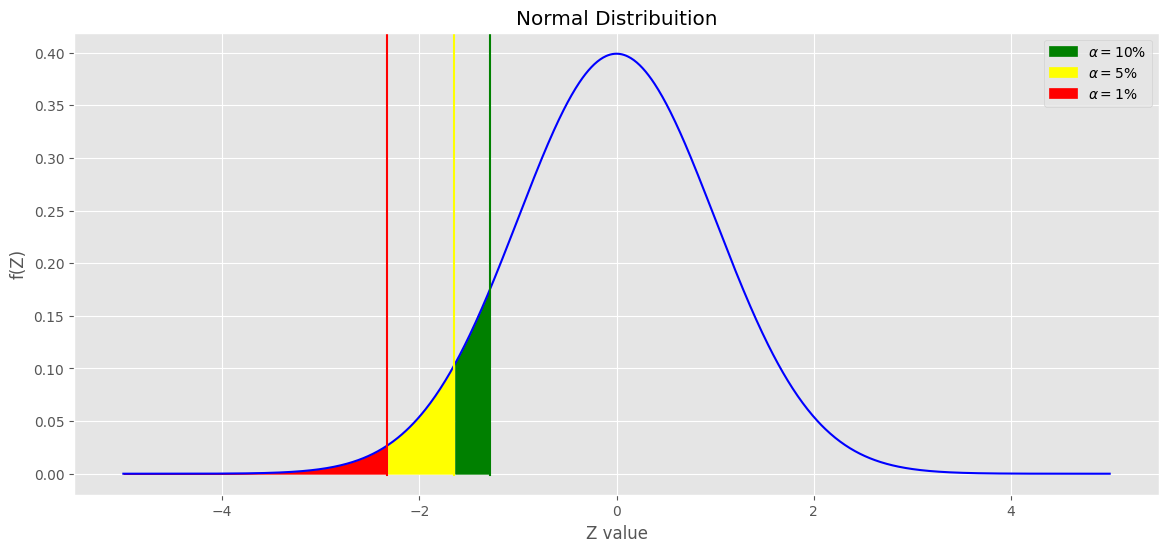

In [3]:
# Parameters and Data
mean = 0
std = 1
x = np.linspace(-5, 5, 1000)
y = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-(x - mean)**2 / (2 * std**2))

plt.figure()
# Creating graph
plt.plot(x, y, color='blue')

# Filling area 
plt.fill_between(x, y, where=((x < -1.28155)&(x >-1.64485)), color='green', alpha=1,label = r'$\alpha = 10$%')
plt.fill_between(x, y, where=((x <-1.64485)&(x >-2.32635 )), color='yellow', alpha=1,label = r'$\alpha = 5$%')
plt.fill_between(x, y, where=((x < -2.32635)), color='red', alpha=1, label = r'$\alpha = 1$%')

plt.axvline(x = -1.28155, color = 'green',ymin=0.0425)
#plt.text(-1.18155,0.4,'Z=-1.18155')
plt.axvline(x = -1.64485, color = 'yellow',ymin=0.0425)
#plt.text(-1.64485,0.35,'Z=-1.64485')
plt.axvline(x = -2.32635, color = 'red',ymin=0.0425)
#plt.text(-2.32635,0.3,'Z=-2.32635')


plt.xlabel('Z value')
plt.ylabel('f(Z)')
plt.title('Normal Distribuition')
plt.legend()

plt.grid(True)
plt.show()

Sometimes is needed to transform the data to fit or almost fit the normal distribution. There are two main trasformation used very often, one is the Simple Rate of Return or effective rate of return that use previus data to provide a percentage variation and the other one is the log-return or logarithmic rate of return:

$$\text{Effective Rate} = \left(\frac{P_t - P_{t-1}}{P_{t-1}}\right) \times 100 $$


$$\text{Logarithmic Rate} = \text{ln}\left(\frac{P_t }{P_{t-1}}\right) \times 100 $$

If the transformed data adjust to normal distribution another transformation to put it to standard normal distribution.

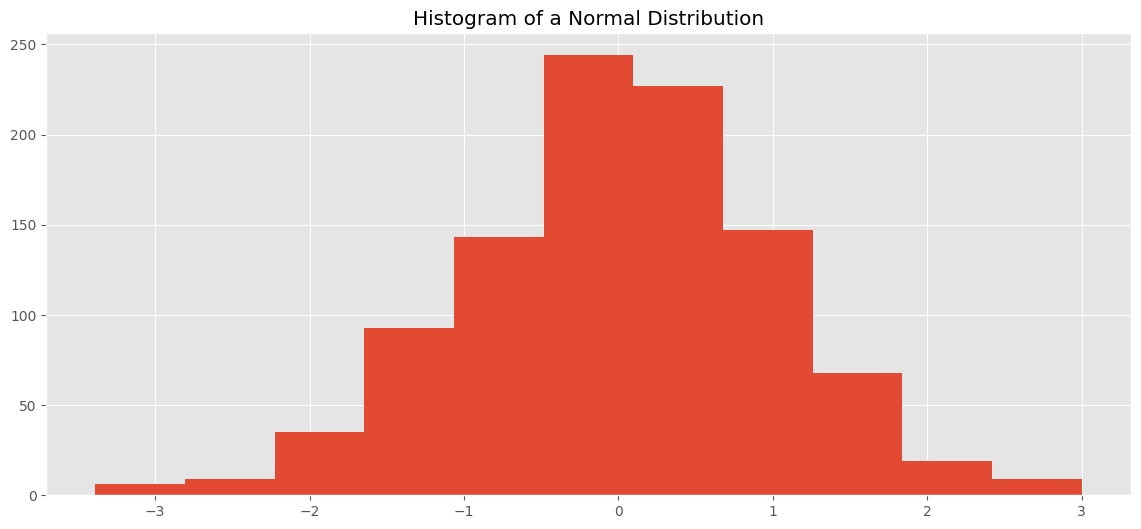

In [4]:
normal = np.random.normal(loc = 0,scale = 1,size =  1000)
plt.figure()
plt.title('Histogram of a Normal Distribution')
plt.hist(normal,bins = 'sturges')

plt.show()

After transformation and fitting to a standard normal distribution, the Z values of 1.18155, 1.64485, and 2.32635 are respectively associated with 10%, 5%, and 1% risk events. Multiplying these Z values by the standard deviation of the data results in the percentage loss at each probability. The Value at Risk(VaR) is the product between potential percentage loss and the last price in the original data.

$$ \alpha(10\%,5\%,1\%) \Rightarrow Z(1.18155, 1.64485, 2.32635) \Rightarrow Z\cdot \sigma \Rightarrow Percentage Loss$$

## Stock Risk Assessment

This section is to the first aplication using real data. Looking for Eletrobrás open price from january first 2022 to 2024.

In [17]:
start_date = dt.datetime(2022, 1, 1)
data_series = pd.DataFrame()
ticker = yf.Ticker("ELET3.SA")
serie = ticker.history(period="2y",start=start_date)
serie.drop(serie.loc[serie['Open']==0].index,inplace=True) # Droping 0 values for stock price
data_series['ELET3'] = serie['Open']

In [6]:
data_series.describe()

,ELET3
count,586.000000
mean,39.026816
std,4.549865
min,28.349255
25%,34.949109
50%,39.610349
75%,42.566581
max,50.422107


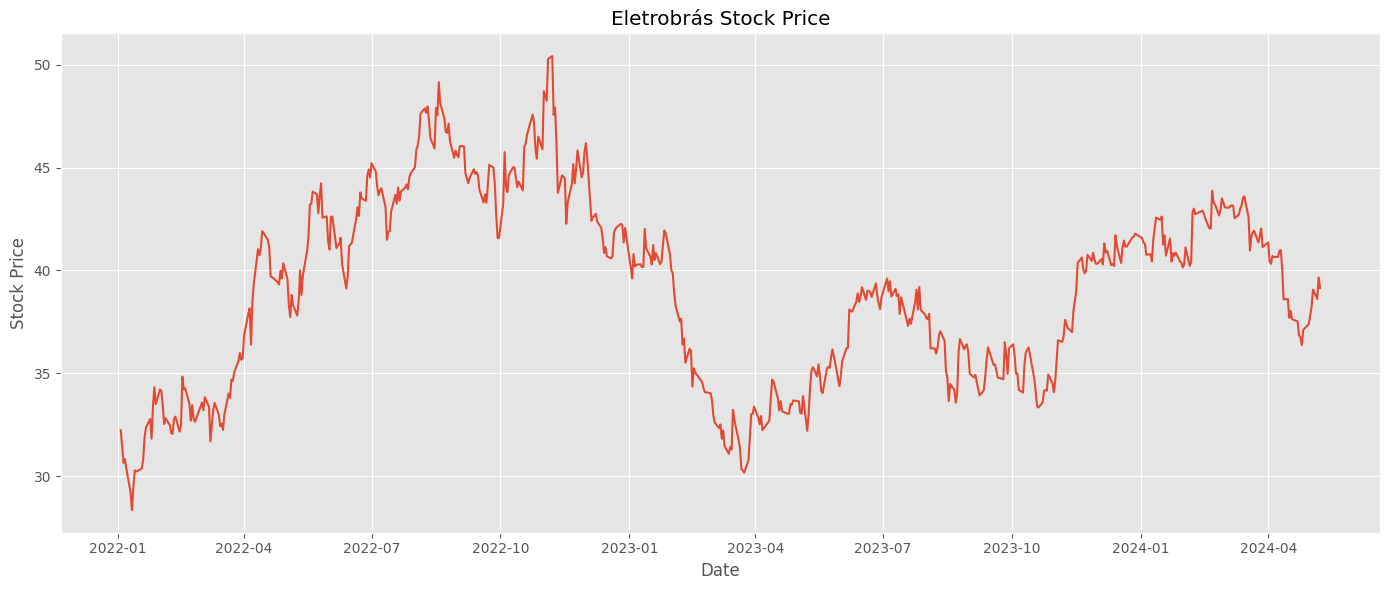

In [7]:
fig = plt.figure(figsize=(14,6))
plt.title('Eletrobrás Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.plot(data_series.index,data_series['ELET3'])
plt.tight_layout()

It is easy to see that the stock price does not fit the normal distribution, but after transformation the rates it fits.

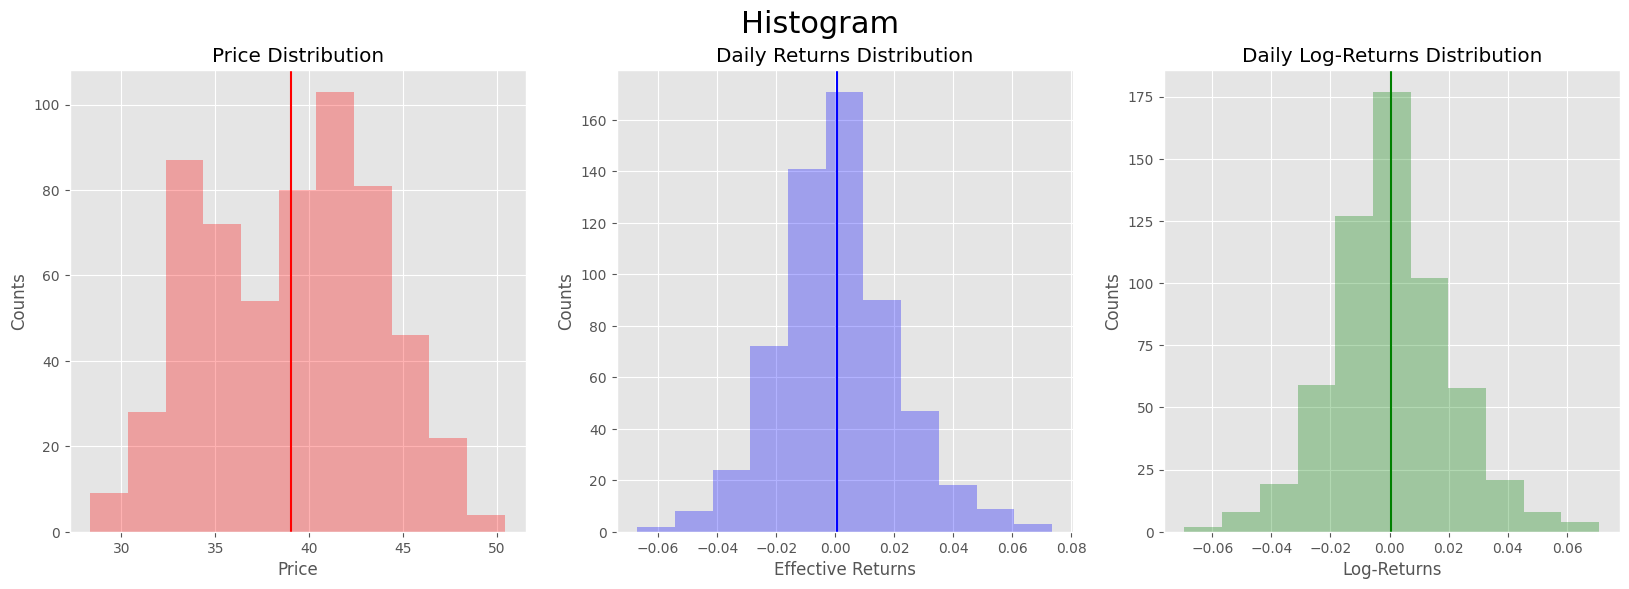

In [8]:
Price = data_series['ELET3'].values
Daily_return = data_series['ELET3'].pct_change().values[1::]
Daily_log_return = np.log(data_series['ELET3']/data_series['ELET3'].shift(1)).values[1::]


fig, axs = plt.subplots(1,3,figsize = (20,6))

plt.suptitle('Histogram',fontsize = 22)
axs[0].hist(Price, bins = 'sturges', alpha = 0.3,color = 'red')
axs[0].axvline(Price.mean(),color = 'red')
axs[0].set_xlabel('Price')
axs[0].set_ylabel('Counts')
axs[0].set_title('Price Distribution')

##
axs[1].hist(Daily_return, bins = 'sturges', alpha = 0.3,color = 'blue')
axs[1].axvline(Daily_return.mean(),color = 'blue')
axs[1].set_xlabel('Effective Returns')
axs[1].set_ylabel('Counts')
axs[1].set_title('Daily Returns Distribution')

##
axs[2].hist(Daily_log_return, bins = 'sturges', alpha = 0.3,color = 'green')
axs[2].axvline(Daily_log_return.mean(),color = 'green')
axs[2].set_xlabel('Log-Returns')
axs[2].set_ylabel('Counts')
axs[2].set_title('Daily Log-Returns Distribution')

plt.show()

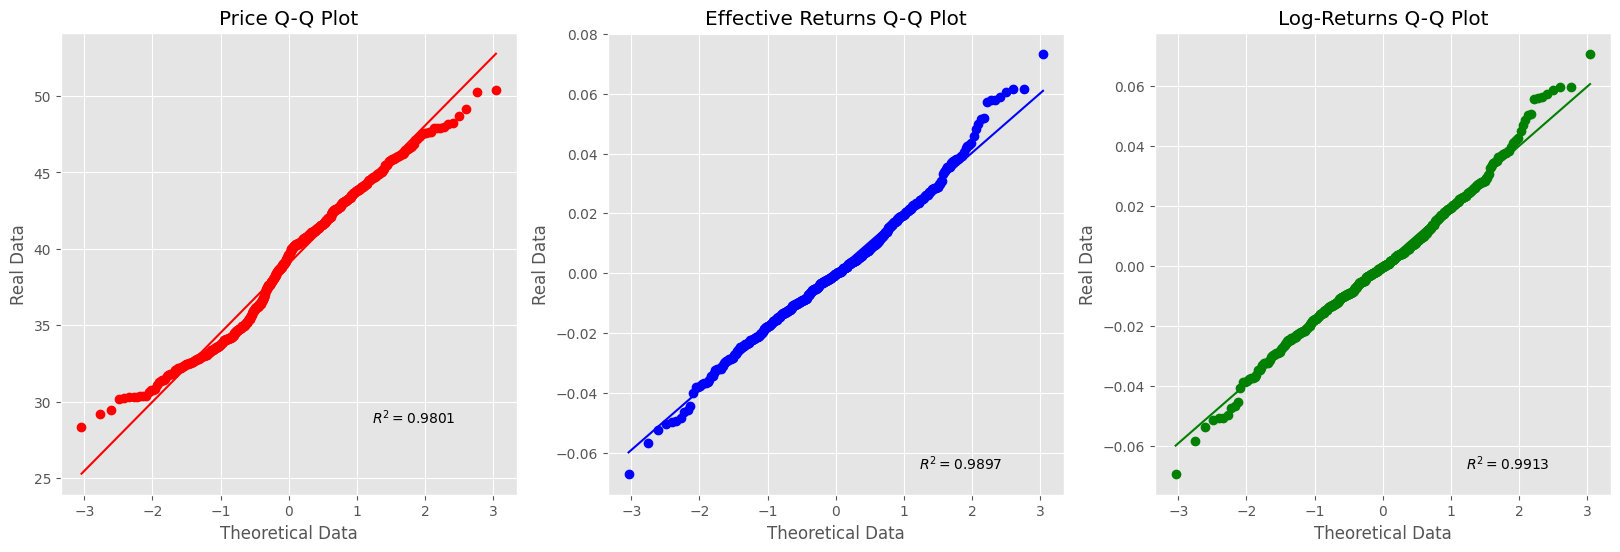

In [9]:
np.random.seed(42)
fig, axs = plt.subplots(1,3,figsize = (20,6))
##
stats.probplot(Price, dist="norm", plot=axs[0],rvalue=True)
axs[0].properties()['children'][1].set_color('red')
axs[0].properties()['children'][0].set_color('red')
axs[0].set_xlabel('Theoretical Data')
axs[0].set_ylabel('Real Data')
axs[0].set_title('Price Q-Q Plot')
##
#sm.qqplot(Daily_return, fit=True, line='s',ax = axs[1])
stats.probplot(Daily_return, dist="norm", plot=axs[1],rvalue=True)
axs[1].properties()['children'][1].set_color('blue')
axs[1].properties()['children'][0].set_color('blue')
axs[1].set_xlabel('Theoretical Data')
axs[1].set_ylabel('Real Data')
axs[1].set_title('Effective Returns Q-Q Plot')
##
stats.probplot(Daily_log_return, dist="norm", plot=axs[2],rvalue=True)
axs[2].properties()['children'][1].set_color('green')
axs[2].properties()['children'][0].set_color('green')
axs[2].set_xlabel('Theoretical Data')
axs[2].set_ylabel('Real Data')
axs[2].set_title('Log-Returns Q-Q Plot')

plt.show()


In [10]:
std = Daily_return.std()
mean = Daily_return.mean()
# Transforming to Standard Normal Distribution
last_price = Price[-1]
# Z values to each Risk
risk10 = 1.28155
risk05 = 1.64485
risk01 =  2.32635
# Potential PERcentage Loss at each Risk
## Transforming
Per10 = (-1*(std*risk10)+mean)
Per05 = (-1*(std*risk05)+mean)
Per01 = (-1*(std*risk01)+mean)
# Value at Risk at each Risk
Var10 = last_price*(Per10)
Var05 = last_price*(Per05)
Var01 = last_price*(Per01)
# Minimun Stock Price at each Risk  
Min10 = last_price + Var10
Min05 = last_price + Var05
Min01 = last_price + Var01


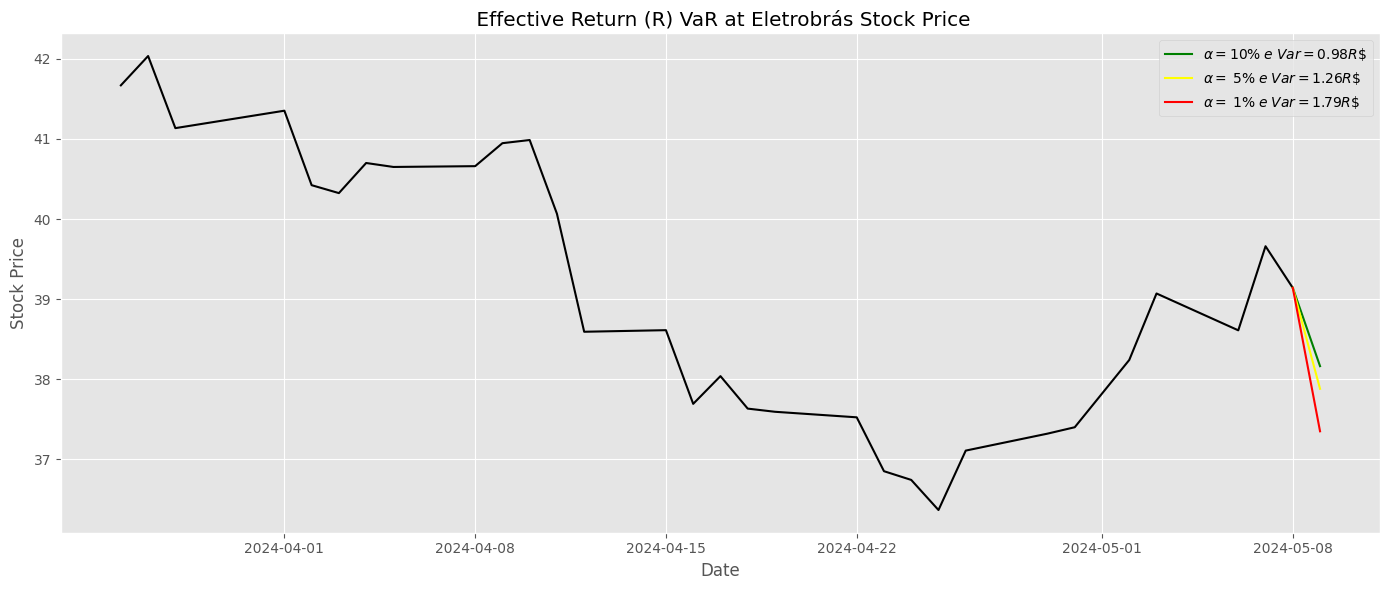

In [11]:
last_day = serie.index[-1] + dt.timedelta(days = 1)

fig = plt.figure(figsize=(14,6))
plt.title(' Effective Return (R) VaR at Eletrobrás Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.plot(serie.index[-30::],Price[-30::],color = 'black')
plt.plot([serie.index[-1],last_day],[last_price,Min10],label = rf'$ \alpha  = 10\% \; e \; Var = {np.abs(round(Var10,2))}  R\$ $' ,color = 'green')
plt.plot([serie.index[-1],last_day],[last_price,Min05],label = rf'$ \alpha  = \; 5\% \; e \; Var = {np.abs(round(Var05,2))}  R\$ $' ,color = 'yellow')
plt.plot([serie.index[-1],last_day],[last_price,Min01],label = rf'$ \alpha  = \; 1\% \; e \; Var = {np.abs(round(Var01,2))}  R\$ $' ,color = 'red')
plt.legend()
plt.tight_layout()

In [12]:
std = Daily_log_return.std()
mean = Daily_log_return.mean()
# Transforming to Standard Normal Distribution
last_price = Price[-1]
# Z values to each Risk
risk10 = 1.28155
risk05 = 1.64485
risk01 =  2.32635
# Potential Percentage Loss at each Risk
## Transforming
Per10 = np.exp((-1*(std*risk10)+mean))
Per05 = np.exp((-1*(std*risk05)+mean))
Per01 = np.exp((-1*(std*risk01)+mean))
# Value at Risk at each Risk
Min10 = last_price*(Per10)
Min05 = last_price*(Per05)
Min01 = last_price*(Per01)
# Minimun Stock Price at each Risk  
Var10= last_price - Min10
Var05= last_price - Min05
Var01= last_price - Min01


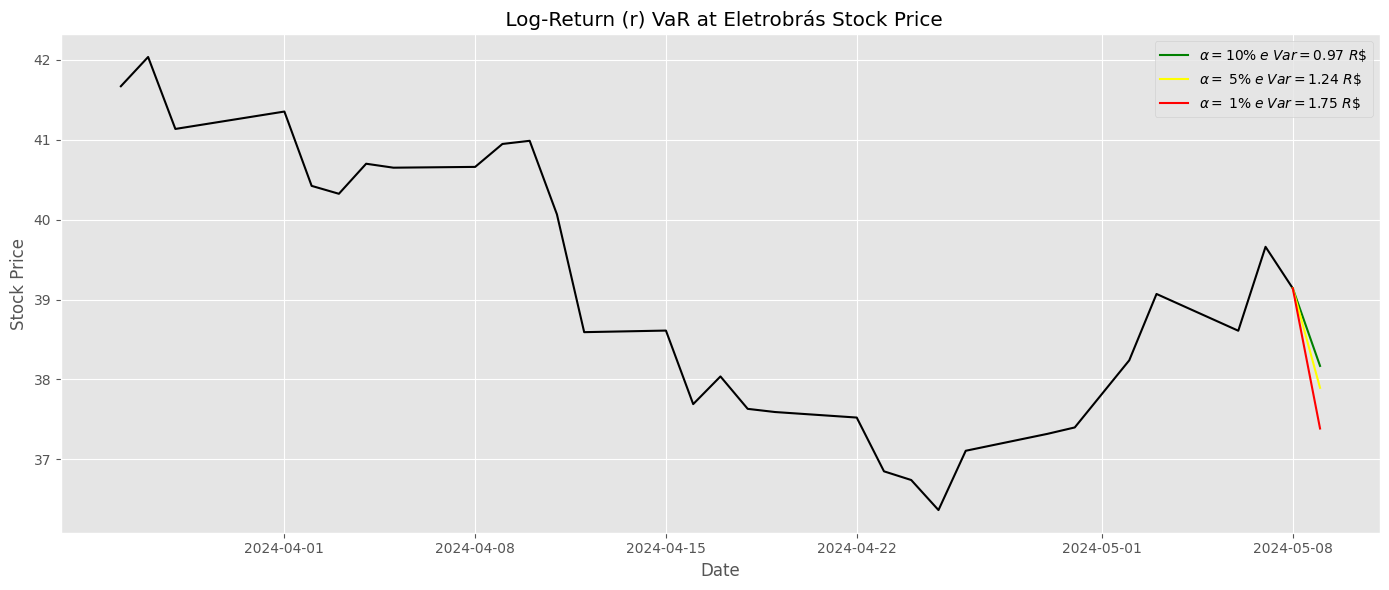

In [13]:
last_day = serie.index[-1] + dt.timedelta(days = 1)

fig = plt.figure(figsize=(14,6))
plt.title(' Log-Return (r) VaR at Eletrobrás Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.plot(serie.index[-30::],Price[-30::],color = 'black')
plt.plot([serie.index[-1],last_day],[last_price,Min10],label = rf'$ \alpha  = 10\% \; e \; Var = {np.abs(round(Var10,2))} \ R\$ $' ,color = 'green')
plt.plot([serie.index[-1],last_day],[last_price,Min05],label = rf'$ \alpha  = \; 5\% \; e \; Var = {np.abs(round(Var05,2))} \ R\$ $' ,color = 'yellow')
plt.plot([serie.index[-1],last_day],[last_price,Min01],label = rf'$ \alpha  = \; 1\% \; e \; Var = {np.abs(round(Var01,2))} \ R\$ $' ,color = 'red')
plt.legend()
plt.tight_layout()

Let's define a function to calculate de Value at Risk

In [5]:
# Effective Return(R)
def RVar(time_serie):
    std = time_serie.std()
    mean = time_serie.mean()
    # Z values to each Risk
    risk10 = 1.28155
    risk05 = 1.64485
    risk01 =  2.32635
    # Potential Percentage Loss at each Risk
    ## Transforming back from standard normal distribution
    Var10 = (-1*(std*risk10)+mean)
    Var05 = (-1*(std*risk05)+mean)
    Var01 = (-1*(std*risk01)+mean)
    return [Var10,Var05,Var01]
#Log-return(r)
def rVar(time_serie):
    std = time_serie.std()
    mean = time_serie.mean()
    # Z values to each Risk
    risk10 = 1.28155
    risk05 = 1.64485
    risk01 =  2.32635
    # Potential Percentage Loss at each Risk
    ## Transforming back from standard normal distribution
    Var10 = (np.exp(-1*(std*risk10)+mean))
    Var05 = (np.exp(-1*(std*risk05)+mean))
    Var01 = (np.exp(-1*(std*risk01)+mean))
    return [Var10,Var05,Var01]

## Portifolio Risk Assessment

This section is to apply the method to a Portifolio, using the set of stocks in the Electric Power Index(IEE) as Stock Portifolio. The stocks in the index at 10/01/2023 are:
* AESB3	   (AES)
* ALUP11   (ALUPAR)
* AURE3	   (AUREN)
* CMIG4	   (CEMIG)	
* COCE5	   (COELCE)	
* CPLE6	   (COPEL)
* CPFE3	   (CPFL ENERGIA)
* ELET3	   (ELETROBRAS)
* ENGI11   (ENERGISA)
* ENEV3	   (ENEVA)
* EGIE3	   (ENGIE BRASIL)
* EQTL3	   (EQUATORIAL)
* NEOE3	   (NEOENERGIA)	
* SRNA3	   (SERENA)
* TAEE11   (TAESA)
* TRPL4    (TRAN PAULIST)

In real life, the stocks that make up the index are not fixed, they depend on some factors. For simplification purposes, the same stocks will stay throughout the analyzed period. If any stock was splited in the process, the the fplit factor will be considered on the weight to correct.

In [18]:
start_date = dt.datetime(2023, 1, 1)# Look for other windows of 2y (like 2017)
data_series = pd.DataFrame()
# Split treatment is needed 

stocks = ['AESB3', 'ALUP11','AURE3','CMIG4','COCE5','CPLE6','CPFE3','ELET3','ENGI11','ENEV3','EGIE3','EQTL3','NEOE3','SRNA3','TAEE11','TRPL4']
partitions = [6.203 , 6.179 , 6.260 , 6.609 , 5.946 , 6.157 , 6.185 , 6.098 , 6.392 , 6.066 , 6.115 , 6.116 , 6.559 , 6.376 , 6.296 , 6.443] 
for i in range(0,len(stocks)):
    stock = stocks[i]
    weight = partitions[i]
    ticker = yf.Ticker(stock+'.SA')
    serie = ticker.history(period="2y",start=start_date)
    serie.drop(serie.loc[serie['Open']==0].index,inplace=True) # Droping 0 values for stock price
    if(len(serie['Open'].values) != 0 ):
        print(stock)
        data_series[f'{stock}'] = weight*serie['Open']/100
    else:
        print(f'{stock} data not avaible')
data_series.fillna(method='ffill', inplace=True) # Filling missing days with price of the previous day
data_series['Total'] = data_series.sum(axis=1) # Sum of the stocks weighted price


AESB3
ALUP11
AURE3
CMIG4
COCE5
CPLE6
CPFE3
ELET3
ENGI11
ENEV3
EGIE3
EQTL3
NEOE3
SRNA3
TAEE11
TRPL4


In [19]:
data_series.describe()

,AESB3,ALUP11,AURE3,CMIG4,COCE5,CPLE6,CPFE3,ELET3,ENGI11,ENEV3,EGIE3,EQTL3,NEOE3,SRNA3,TAEE11,TRPL4,Total
count,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000
mean,0.668323,1.632145,0.762081,0.532965,2.583850,0.518061,1.919280,2.298692,2.913382,0.735965,2.417392,1.867098,1.152410,0.607769,2.112735,1.473311,24.195459
std,0.058972,0.114914,0.028079,0.053035,0.320949,0.071212,0.176865,0.204937,0.301775,0.044729,0.155790,0.193013,0.181128,0.058202,0.088229,0.138826,1.577034
min,0.564217,1.370396,0.698470,0.425341,1.967479,0.389790,1.538808,1.839450,2.242959,0.609633,2.040281,1.457318,0.831868,0.489039,1.878621,1.255358,20.470829
25%,0.621439,1.583947,0.741942,0.504462,2.394758,0.457605,1.759708,2.122148,2.696745,0.706386,2.332444,1.677568,0.966389,0.562841,2.042566,1.333855,22.870526
50%,0.655279,1.662346,0.757808,0.538913,2.519903,0.513030,1.979885,2.308708,2.968161,0.740052,2.438222,1.917345,1.202663,0.594562,2.104444,1.472847,24.532610
75%,0.718346,1.707608,0.783100,0.558516,2.781256,0.584700,2.040414,2.474004,3.154712,0.770382,2.540569,2.029820,1.315642,0.639672,2.178003,1.594481,25.527624
max,0.780182,1.826614,0.832552,0.695267,3.356967,0.637854,2.245925,2.674892,3.491310,0.831042,2.688539,2.159761,1.416244,0.745354,2.311310,1.742187,26.804904


There is no missing values for more than one day:

In [20]:
data_series.isna().sum()

AESB3     0
ALUP11    0
AURE3     0
CMIG4     0
COCE5     0
CPLE6     0
CPFE3     0
ELET3     0
ENGI11    0
ENEV3     0
EGIE3     0
EQTL3     0
NEOE3     0
SRNA3     0
TAEE11    0
TRPL4     0
Total     0
dtype: int64

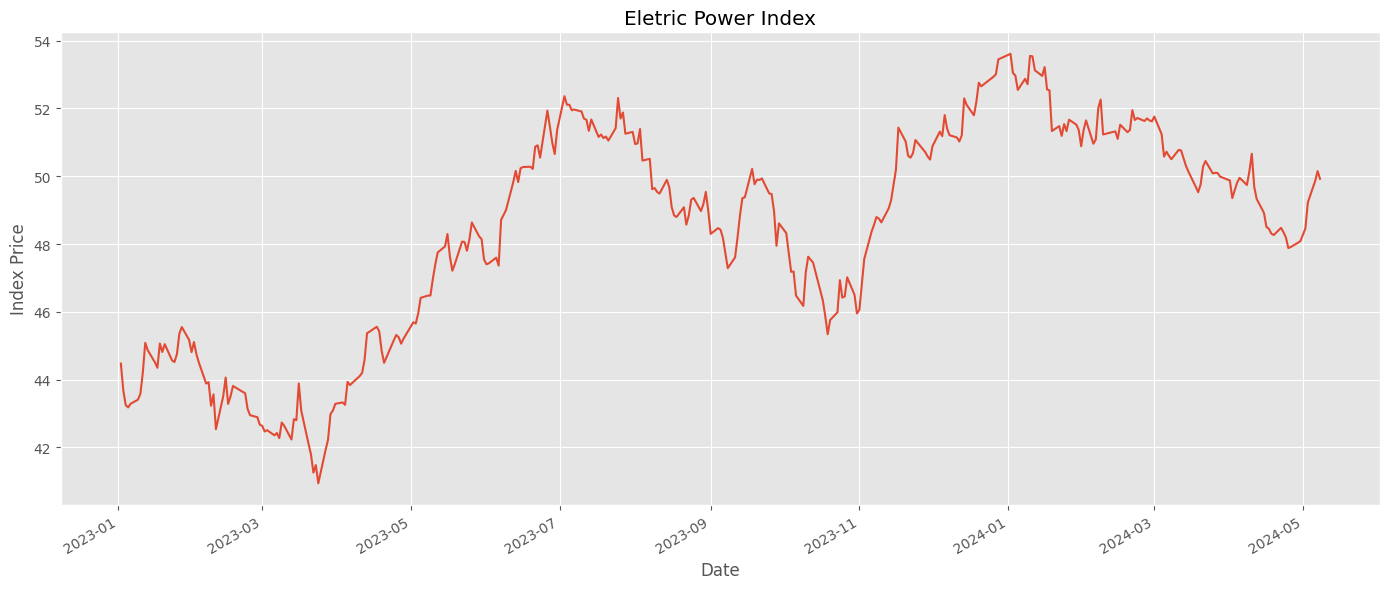

In [21]:
fig = plt.figure(figsize=(14,6))
plt.title('Eletric Power Index')
plt.xlabel('Date')
plt.ylabel('Index Price')
data_series['Total'] = data_series.sum(axis=1)
data_series['Total'].plot()
plt.tight_layout()


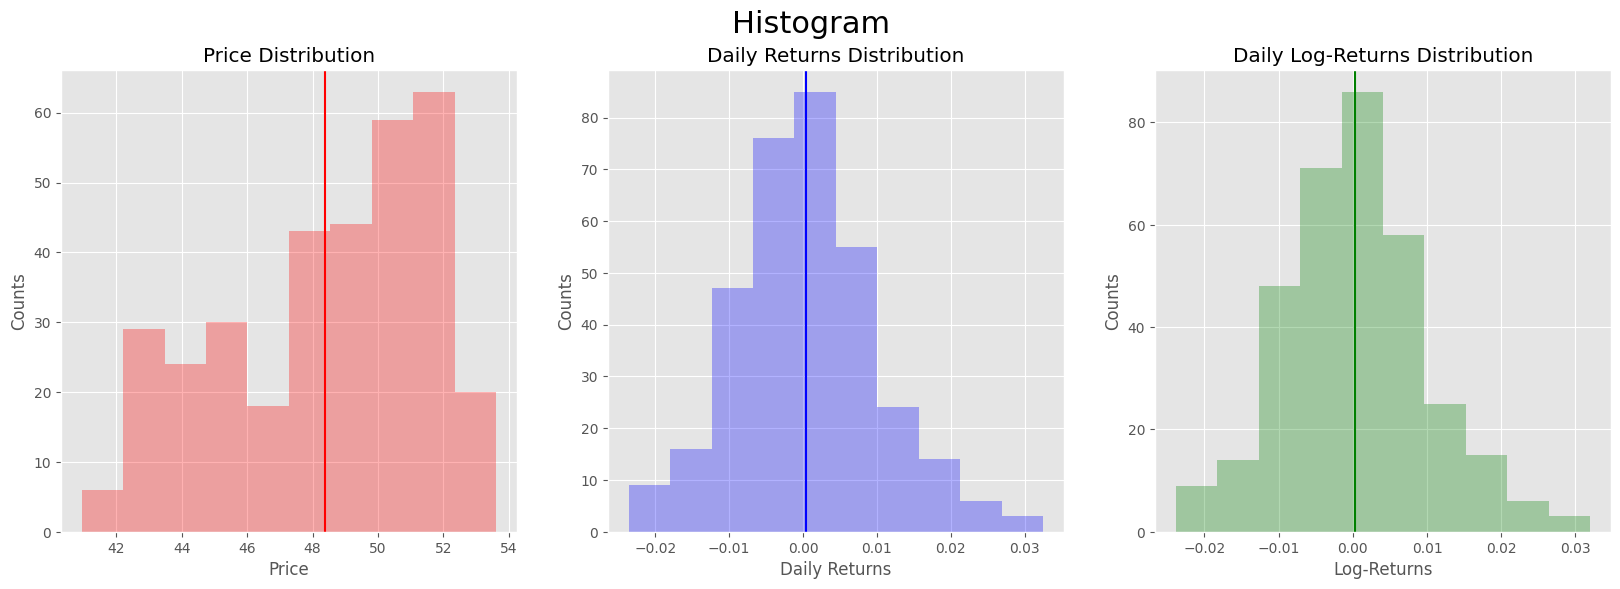

In [22]:
Price = data_series['Total'].values
Daily_return = data_series['Total'].pct_change().values[1::]
Daily_log_return = np.log(data_series['Total']/data_series['Total'].shift(1)).values[1::]

fig, axs = plt.subplots(1,3,figsize = (20,6))

plt.suptitle('Histogram',fontsize = 22)
##
axs[0].hist(Price, bins = 'sturges', alpha = 0.3,color = 'red')
axs[0].axvline(Price.mean(),color = 'red')
axs[0].set_xlabel('Price')
axs[0].set_ylabel('Counts')
axs[0].set_title('Price Distribution')

##
axs[1].hist(Daily_return, bins = 'sturges', alpha = 0.3,color = 'blue')
axs[1].axvline(Daily_return.mean(),color = 'blue')
axs[1].set_xlabel('Daily Returns')
axs[1].set_ylabel('Counts')
axs[1].set_title('Daily Returns Distribution')

##
axs[2].hist(Daily_log_return, bins = 'sturges', alpha = 0.3,color = 'green')
axs[2].axvline(Daily_log_return.mean(),color = 'green')
axs[2].set_xlabel('Log-Returns')
axs[2].set_ylabel('Counts')
axs[2].set_title('Daily Log-Returns Distribution')

plt.show()

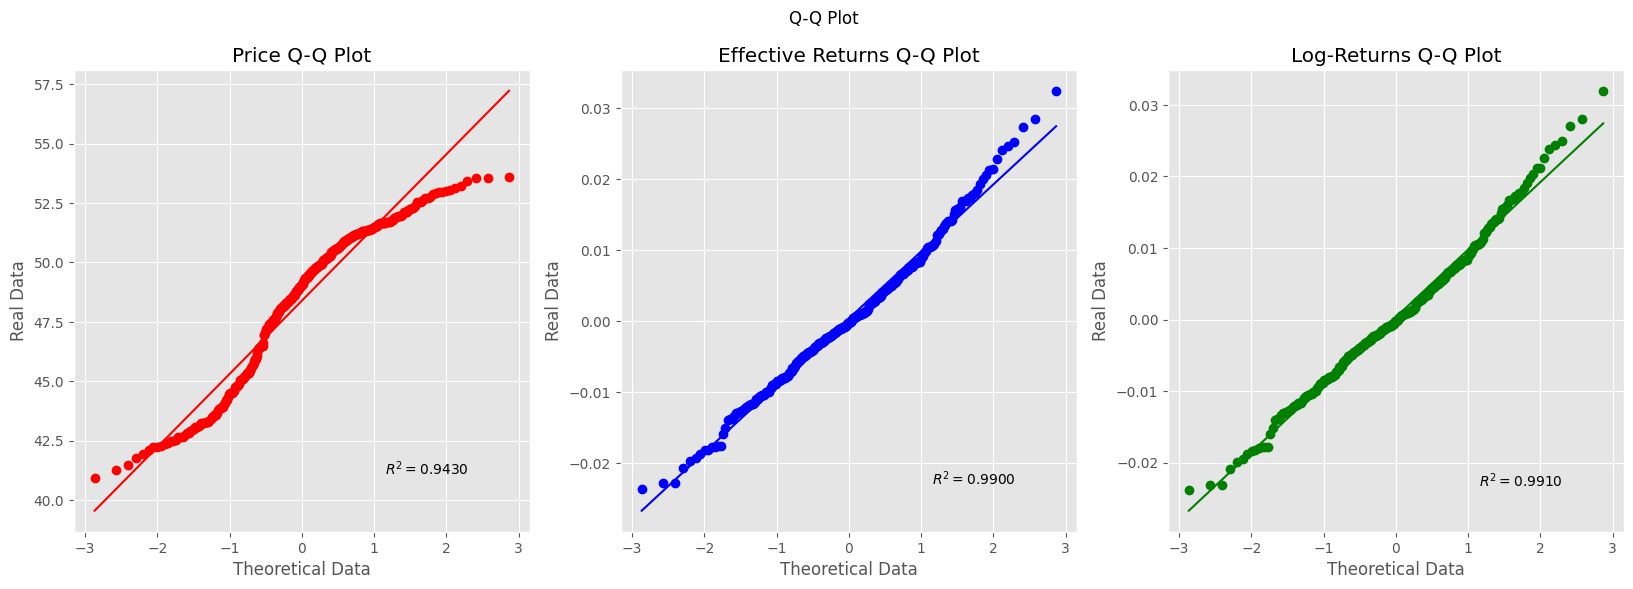

In [27]:
np.random.seed(42)
fig, axs = plt.subplots(1,3,figsize = (20,6))

plt.suptitle('Q-Q Plot')
##
stats.probplot(Price, dist="norm", plot=axs[0],rvalue=True)
axs[0].properties()['children'][1].set_color('red')
axs[0].properties()['children'][0].set_color('red')
axs[0].set_xlabel('Theoretical Data')
axs[0].set_ylabel('Real Data')
axs[0].set_title('Price Q-Q Plot')
##
#sm.qqplot(Daily_return, fit=True, line='s',ax = axs[1])
stats.probplot(Daily_return, dist="norm", plot=axs[1],rvalue=True)
axs[1].properties()['children'][1].set_color('blue')
axs[1].properties()['children'][0].set_color('blue')
axs[1].set_xlabel('Theoretical Data')
axs[1].set_ylabel('Real Data')
axs[1].set_title('Effective Returns Q-Q Plot')
##
stats.probplot(Daily_log_return, dist="norm", plot=axs[2],rvalue=True)
axs[2].properties()['children'][1].set_color('green')
axs[2].properties()['children'][0].set_color('green')
axs[2].set_xlabel('Theoretical Data')
axs[2].set_ylabel('Real Data')
axs[2].set_title('Log-Returns Q-Q Plot')

plt.show()

In [28]:
Risk = RVar(Daily_return)
last_price = Price[-1]

# Potential Percentage Loss
Per10 = Risk[0]
Per05 = Risk[1]
Per01 = Risk[2]
# Value at Risk
Var10 = last_price*(Per10)
Var05 = last_price*(Per05)
Var01 = last_price*(Per01)
# Minimun Stock Price at each Risk  
Min10 = last_price + Var10
Min05 = last_price + Var05
Min01 = last_price + Var01


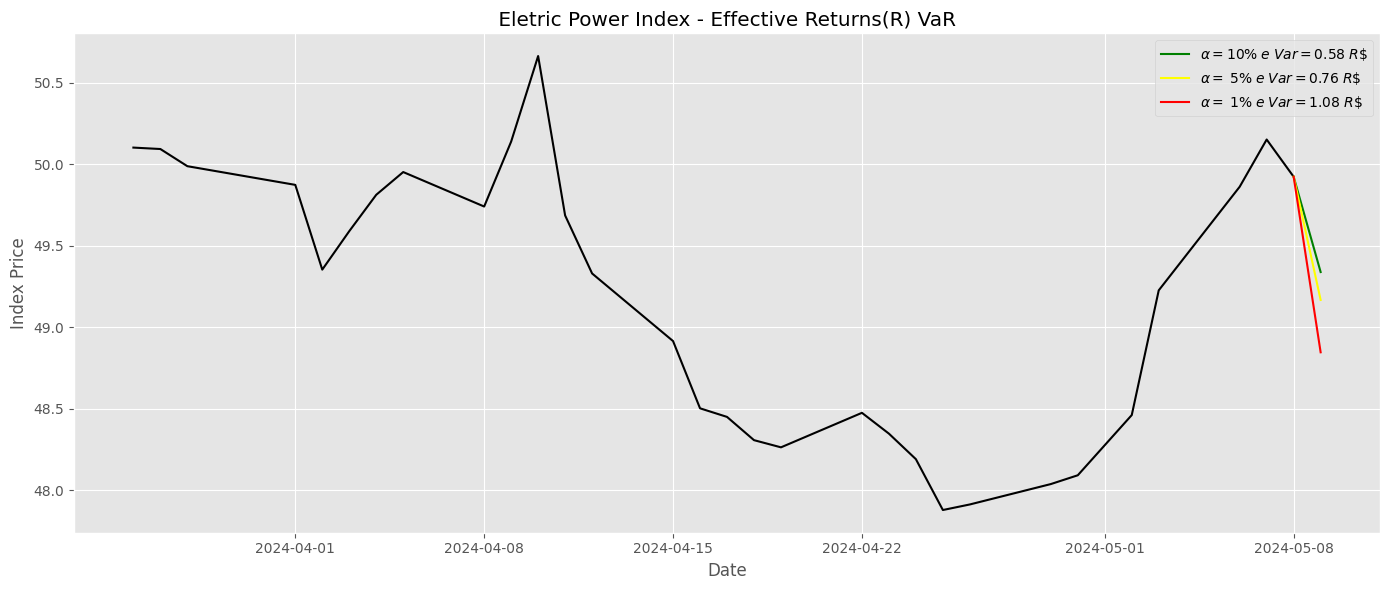

In [29]:
last_day = data_series.index[-1] + dt.timedelta(days = 1)

fig = plt.figure(figsize=(14,6))
plt.title(' Eletric Power Index - Effective Returns(R) VaR ')
plt.xlabel('Date')
plt.ylabel('Index Price')
plt.plot(data_series.index[-30::],Price[-30::],color = 'black')
plt.plot([data_series.index[-1],last_day],[last_price,Min10],label = rf'$ \alpha  = 10\% \; e \; Var = {np.abs(round(Var10,2))}   \; R\$ $' ,color = 'green')
plt.plot([data_series.index[-1],last_day],[last_price,Min05],label = rf'$ \alpha  = \; 5\% \; e \; Var = {np.abs(round(Var05,2))} \; R\$ $' ,color = 'yellow')
plt.plot([data_series.index[-1],last_day],[last_price,Min01],label = rf'$ \alpha  = \; 1\% \; e \; Var = {np.abs(round(Var01,2))} \; R\$ $' ,color = 'red')
plt.legend()
plt.tight_layout()

In [30]:
Risk = rVar(Daily_log_return)
last_price = Price[-1]

# Potential Percentage Loss
Per10 = Risk[0]
Per05 = Risk[1]
Per01 = Risk[2]
# Minimun Stock Price at each Risk  
Min10 = last_price*(Per10)
Min05 = last_price*(Per05)
Min01 = last_price*(Per01)
# Value at Risk at each Risk
Var10= last_price - Min10
Var05= last_price - Min05
Var01= last_price - Min01

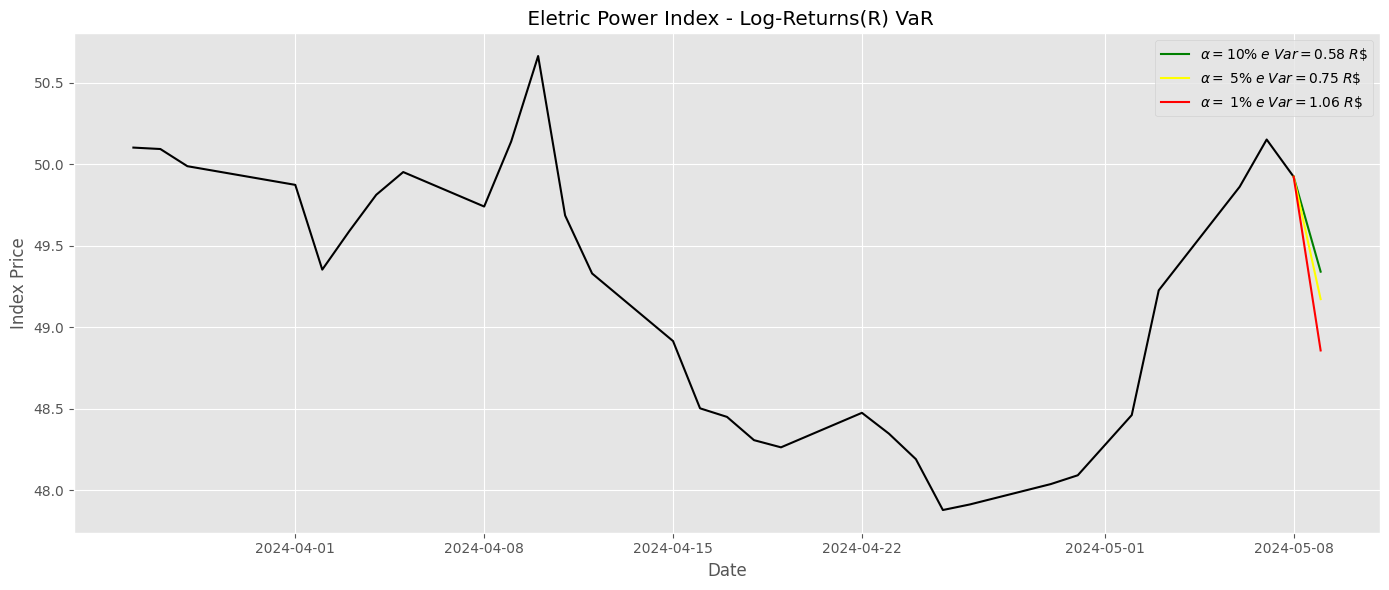

In [31]:
last_day = data_series.index[-1] + dt.timedelta(days = 1)

fig = plt.figure(figsize=(14,6))
plt.title(' Eletric Power Index - Log-Returns(R) VaR')
plt.xlabel('Date')
plt.ylabel('Index Price')
plt.plot(data_series.index[-30::],Price[-30::],color = 'black')
plt.plot([data_series.index[-1],last_day],[last_price,Min10],label = rf'$ \alpha  = 10\% \; e \; Var = {np.abs(round(Var10,2))}   \; R\$ $' ,color = 'green')
plt.plot([data_series.index[-1],last_day],[last_price,Min05],label = rf'$ \alpha  = \; 5\% \; e \; Var = {np.abs(round(Var05,2))} \; R\$ $' ,color = 'yellow')
plt.plot([data_series.index[-1],last_day],[last_price,Min01],label = rf'$ \alpha  = \; 1\% \; e \; Var = {np.abs(round(Var01,2))} \; R\$ $' ,color = 'red')
plt.legend()
plt.tight_layout()

## Validation

10 days Sliding window 

### Stock Validation

In [2]:
import warnings

# Desativar todos os warnings temporariamente
warnings.filterwarnings("ignore")

In [3]:
start_date = dt.datetime(2022, 1, 1)# Look for other windows of 2y (like 2017)
data_series = pd.DataFrame()
ticker = yf.Ticker("ELET3.SA")
serie = ticker.history(period="2y",start=start_date)
serie.drop(serie.loc[serie['Close']==0].index,inplace=True) # Droping 0 values for stock price
data_series['ELET3'] = serie['Close']


#### Effective Return (R)

In [40]:
predict = pd.DataFrame()
window_var = []

for i in range(0,len(data_series)-10):
    window = data_series.iloc[i:i+10]
    last_price = window.values[-1]
    Daily_return = window.pct_change().values[1:-1]
    Risk = RVar(Daily_return)
    # 1% Risk Loss
    Per01 = Risk[2]
    #Value at Risk
    Var01 = last_price*(Per01)
    # Minimun Stock Price
    Min01 = last_price+Var01
    window_var.append(Min01[0])


predict['Date']= data_series.index[10:len(data_series)]
predict['Real'] = data_series['ELET3'].values[10:len(data_series)]
predict['Effective_Retrurn_Var'] = np.array(window_var)
predict


,Date,Real,Var
0,2022-01-17 00:00:00-03:00,30.547020,28.395985
1,2022-01-18 00:00:00-03:00,30.556660,28.618712
2,2022-01-19 00:00:00-03:00,31.848330,28.653578
3,2022-01-20 00:00:00-03:00,32.243546,29.872755
4,2022-01-21 00:00:00-03:00,32.764069,30.790118
...,...,...,...
571,2024-05-02 00:00:00-03:00,38.380001,36.993626
572,2024-05-03 00:00:00-03:00,38.950001,37.544064
573,2024-05-06 00:00:00-03:00,39.180000,38.126995
574,2024-05-07 00:00:00-03:00,39.400002,38.409705


In [41]:
cross = predict.loc[predict['Real']<=predict['Var']]
print(f'The ELET3 stock crossed the Value at Risk line {len(cross)} times in {len(predict)} days resulting in an {round(100*len(cross)/len(predict),2)}% empirical risk in comparasion to the theorical risk of 1%.')

The ELET3 stock crossed the Value at Risk line 19 times in 576 days resulting in an 3.3% empirical risk in comparasion to the theorical risk of 1%.


The stock price was below the 1% risk line 2 times in 114 days. 
 The percentage of the emprical risk is 1.75%.


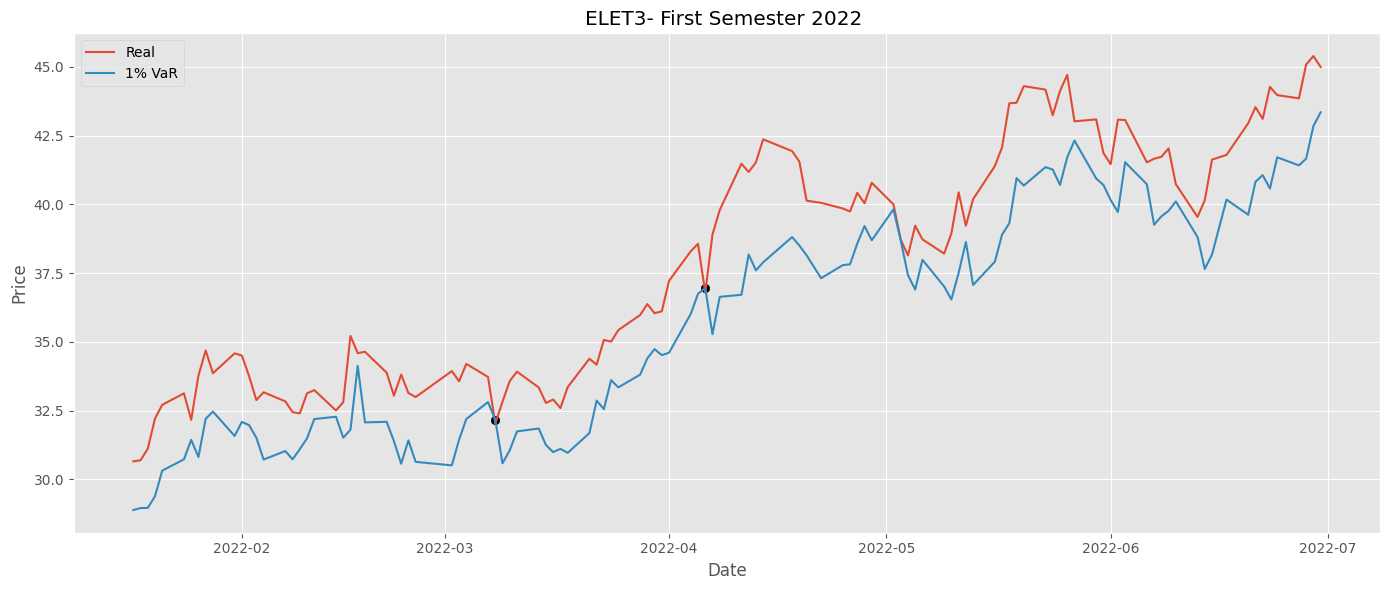

In [143]:
month = 7
year = 2022
#interval = predict[((predict['Date'].dt.month == month1)|(predict['Date'].dt.month == month2))&((predict['Date'].dt.year == year))]
interval = predict[((predict['Date'].dt.month <month )&((predict['Date'].dt.year == year)))]
cross = interval.loc[interval['Real']<=interval['Var']]

empirical_risk = len(cross)/len(interval)
print(f'The stock price was below the 1% risk line {len(cross)} times in {len(interval)} days. \n The percentage of the emprical risk is {round(empirical_risk*100,2)}%.')

plt.figure()
plt.title(f'ELET3- First Semester {year} ')
plt.scatter(cross['Date'],cross['Var'],color = 'Black')
plt.plot(interval['Date'],interval['Real'],label = 'Real')
plt.plot(interval['Date'],interval['Var'],label = '1% VaR')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()

The stock price was below the 1% risk line 4 times in 126 days. 
 The percentage of the emprical risk is 3.17%.


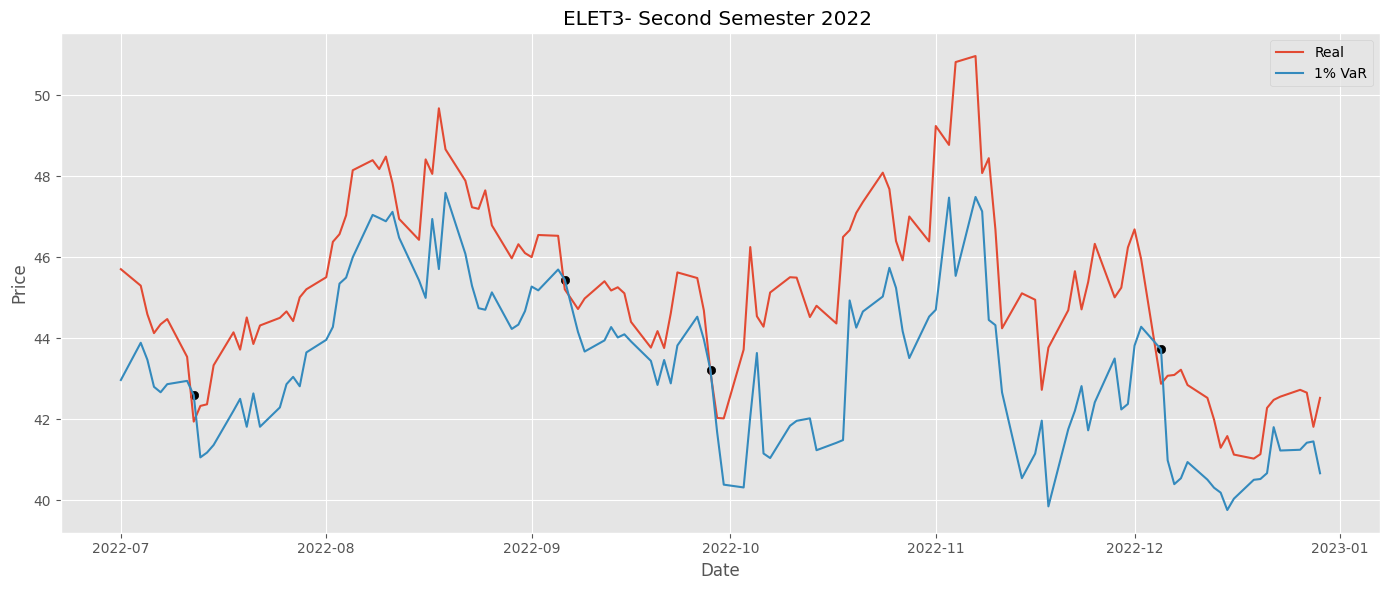

In [144]:
month = 7
year = 2022
#interval = predict[((predict['Date'].dt.month == month1)|(predict['Date'].dt.month == month2))&((predict['Date'].dt.year == year))]
interval = predict[((predict['Date'].dt.month >=month )&((predict['Date'].dt.year == year)))]
cross = interval.loc[interval['Real']<=interval['Var']]

empirical_risk = len(cross)/len(interval)
print(f'The stock price was below the 1% risk line {len(cross)} times in {len(interval)} days. \n The percentage of the emprical risk is {round(empirical_risk*100,2)}%.')


plt.title(f'ELET3- Second Semester {year} ')
plt.scatter(cross['Date'],cross['Var'],color = 'Black')
plt.plot(interval['Date'],interval['Real'],label = 'Real')
plt.plot(interval['Date'],interval['Var'],label = '1% VaR')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()

The stock price was below the 1% risk line 8 times in 124 days. 
 The percentage of the emprical risk is 6.45%.


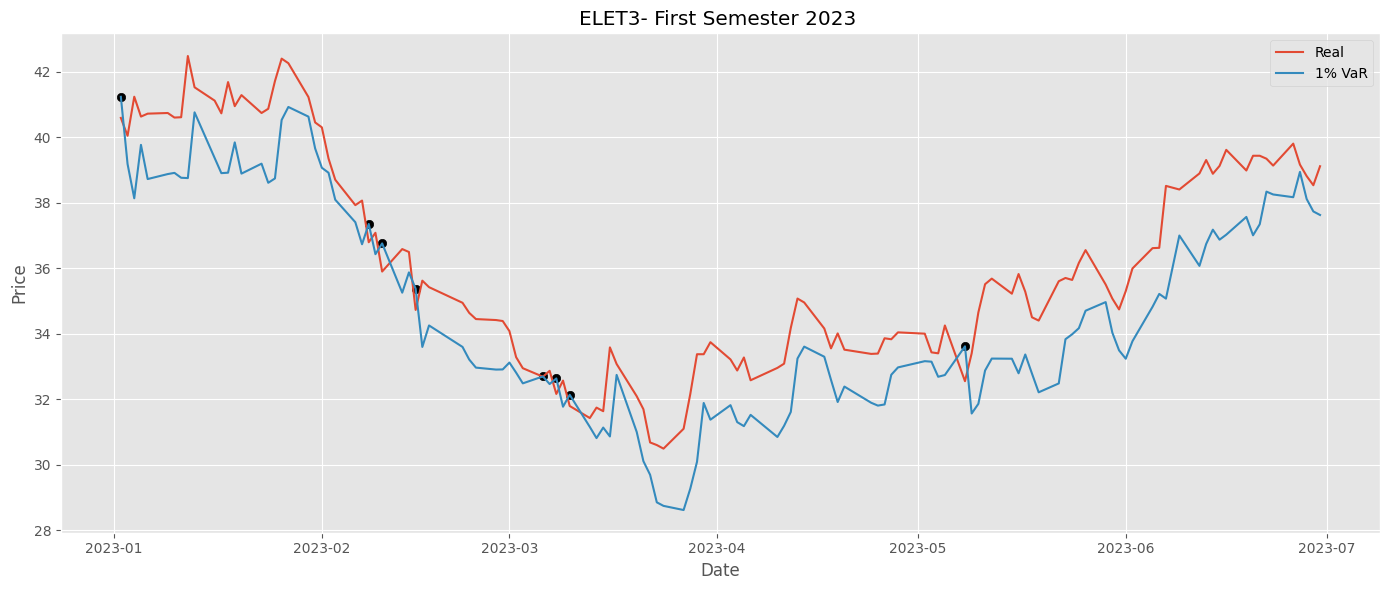

In [145]:
month = 7
year = 2023
#interval = predict[((predict['Date'].dt.month == month1)|(predict['Date'].dt.month == month2))&((predict['Date'].dt.year == year))]
interval = predict[((predict['Date'].dt.month <month )&((predict['Date'].dt.year == year)))]
cross = interval.loc[interval['Real']<=interval['Var']]

empirical_risk = len(cross)/len(interval)
print(f'The stock price was below the 1% risk line {len(cross)} times in {len(interval)} days. \n The percentage of the emprical risk is {round(empirical_risk*100,2)}%.')


plt.title(f'ELET3- First Semester {year} ')
plt.scatter(cross['Date'],cross['Var'],color = 'Black')
plt.plot(interval['Date'],interval['Real'],label = 'Real')
plt.plot(interval['Date'],interval['Var'],label = '1% VaR')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()

The stock price was below the 1% risk line 1 times in 124 days. 
 The percentage of the emprical risk is 0.81%.


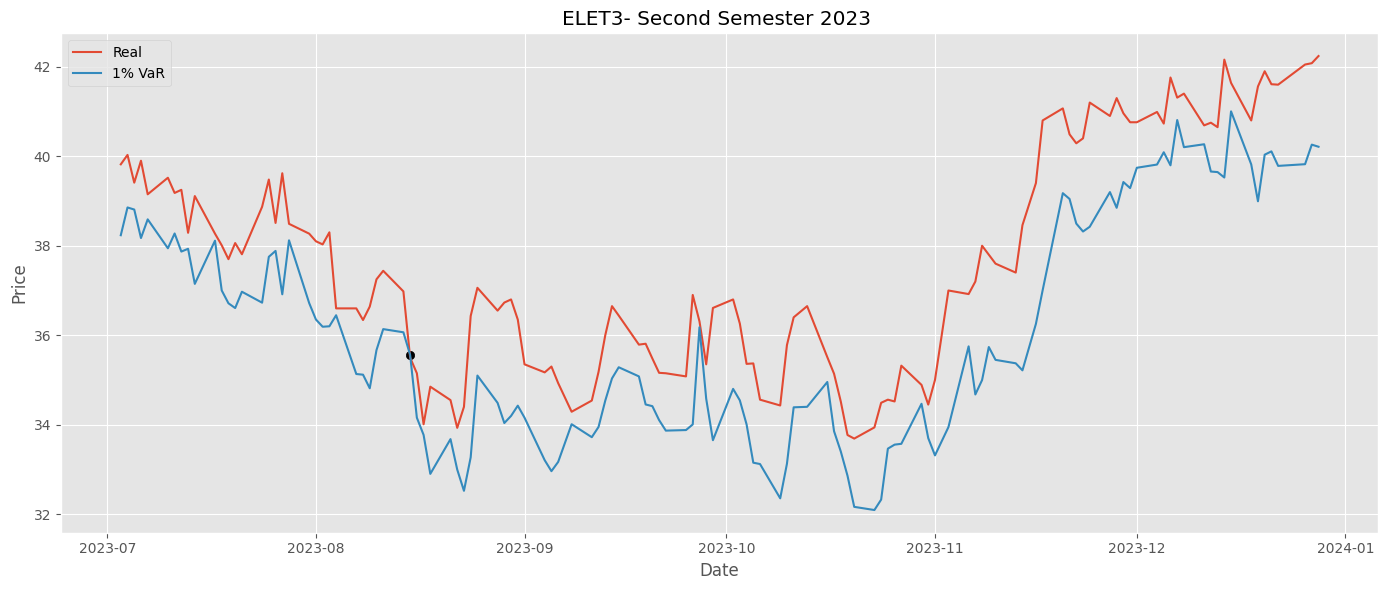

In [146]:
month = 7
year = 2023
#interval = predict[((predict['Date'].dt.month == month1)|(predict['Date'].dt.month == month2))&((predict['Date'].dt.year == year))]
interval = predict[((predict['Date'].dt.month >=month )&((predict['Date'].dt.year == year)))]
cross = interval.loc[interval['Real']<=interval['Var']]

empirical_risk = len(cross)/len(interval)
print(f'The stock price was below the 1% risk line {len(cross)} times in {len(interval)} days. \n The percentage of the emprical risk is {round(empirical_risk*100,2)}%.')

plt.figure()
plt.title(f'ELET3- Second Semester {year} ')
plt.scatter(cross['Date'],cross['Var'],color = 'Black')
plt.plot(interval['Date'],interval['Real'],label = 'Real')
plt.plot(interval['Date'],interval['Var'],label = '1% VaR')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()

#### Log-Returns(r)

10 window lenght

In [34]:
data_series.head()

,ELET3
Date,
2022-01-03 00:00:00-03:00,32.233900
2022-01-04 00:00:00-03:00,31.443478
2022-01-05 00:00:00-03:00,30.643414
2022-01-06 00:00:00-03:00,30.816923
2022-01-07 00:00:00-03:00,30.363874


In [7]:
predict = pd.DataFrame()
window_Effective_r_var = []
window_Log_r_var = []


for i in range(0,len(data_series)-10):
    window = data_series.iloc[i:i+10]
    last_price = window.values[-1]
    # Each measure of return
    Daily_return = window.pct_change().values[1::]
    Daily_log_return = np.log(window['ELET3']/window['ELET3'].shift(1)).values[1::]
    
    Effective_r_Risk = RVar(Daily_return)
    Log_r_Risk = rVar(Daily_log_return)
    
    # Effective Return 
    ## 1% Risk Loss
    Effective_r_Per01 = Effective_r_Risk[2]
    ## Value at Risk
    Effective_r_Var01 = last_price*(Effective_r_Per01)
    ## Minimun Stock Price
    Effective_r_Min01 = last_price+Effective_r_Var01
    
    # Log Return
    ## 1% Risk Loss
    Log_r_Per01 = Log_r_Risk[2]
    ## Minimun Stock Price
    Log_r_Min01 = last_price*Log_r_Per01
    ## Value at Risk
    Log_r_Var01 = last_price- Log_r_Min01

    window_Effective_r_var.append(Effective_r_Min01)
    window_Log_r_var.append(Log_r_Min01)


predict['Date']= data_series.index[10:len(data_series)]
predict['Real'] = data_series['ELET3'].values[10:len(data_series)]
predict['Effective_Return_Var'] = np.array(window_Effective_r_var)
predict['Log_Return_Var'] = np.array(window_Log_r_var)
predict


,Date,Real,Effective_Return_Var,Log_Return_Var
0,2022-01-17 00:00:00-03:00,30.547022,28.527632,28.583994
1,2022-01-18 00:00:00-03:00,30.556662,28.737432,28.785623
2,2022-01-19 00:00:00-03:00,31.848330,28.763594,28.810449
3,2022-01-20 00:00:00-03:00,32.243546,29.893261,29.948795
4,2022-01-21 00:00:00-03:00,32.764069,30.898356,30.939309
...,...,...,...,...
573,2024-05-06 00:00:00-03:00,39.180000,38.173100,38.179383
574,2024-05-07 00:00:00-03:00,39.400002,38.467720,38.472186
575,2024-05-08 00:00:00-03:00,39.590000,38.981442,38.982761
576,2024-05-09 00:00:00-03:00,38.110001,39.586188,39.587998


In [8]:
Effective_cross = predict.loc[predict['Real']<=predict['Effective_Return_Var']]
Log_cross = predict.loc[predict['Real']<=predict['Log_Return_Var']]
print(f'Using the effective return the ELET3 stock crossed the Value at Risk line {len(Effective_cross)} times in {len(predict)} days resulting in an {round(100*len(Effective_cross)/len(predict),2)}% real risk in comparasion to the theorical risk of 1%.\n')
print(f'Using the log-return the ELET3 stock crossed the Value at Risk line {len(Log_cross)} times in {len(predict)} days resulting in an {round(100*len(Log_cross)/len(predict),2)}% real risk in comparasion to the theorical risk of 1%.\n')

Using the effective return the ELET3 stock crossed the Value at Risk line 20 times in 578 days resulting in an 3.46% real risk in comparasion to the theorical risk of 1%.

Using the log-return the ELET3 stock crossed the Value at Risk line 20 times in 578 days resulting in an 3.46% real risk in comparasion to the theorical risk of 1%.



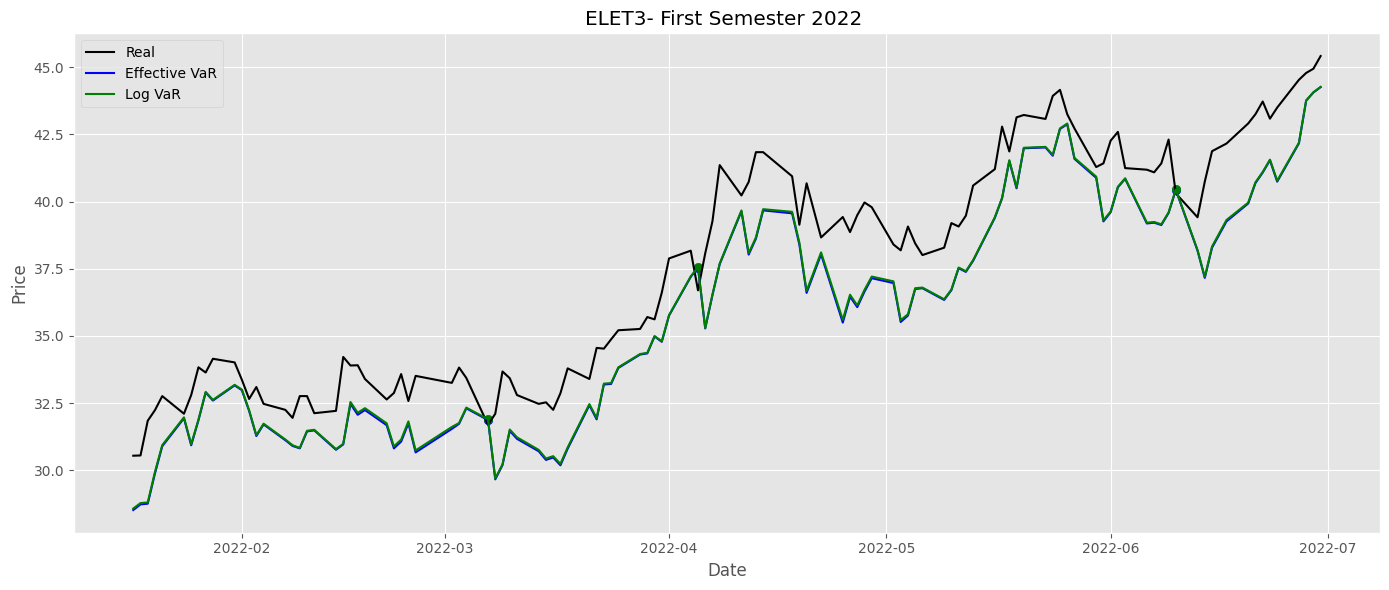

In [11]:
month = 7
year = 2022
#interval = predict[((predict['Date'].dt.month == month1)|(predict['Date'].dt.month == month2))&((predict['Date'].dt.year == year))]
interval = predict[((predict['Date'].dt.month <month )&((predict['Date'].dt.year == year)))]
Effective_cross = interval.loc[interval['Real']<=interval['Effective_Return_Var']]
Log_cross = interval.loc[interval['Real']<=interval['Log_Return_Var']]

Effective_risk = len(Effective_cross)/len(interval)
Log_risk = len(Log_cross)/len(interval)
#print(f'The stock price was below the 1% risk line {len(cross)} times in {len(interval)} days. \n The percentage of the emprical risk is {round(empirical_risk*100,2)}%.')

plt.figure()
plt.title(f'ELET3- First Semester {year} ')
# Crossing Points
plt.scatter(Effective_cross['Date'],Effective_cross['Effective_Return_Var'],color = 'blue')
plt.scatter(Log_cross['Date'],Log_cross['Log_Return_Var'],color = 'green')
#Price Lines
plt.plot(interval['Date'],interval['Real'],label = 'Real',color = 'Black')
plt.plot(interval['Date'],interval['Effective_Return_Var'],label = 'Effective VaR',color = 'blue')
plt.plot(interval['Date'],interval['Log_Return_Var'],label = 'Log VaR',color = 'green')
#
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()

#### Details

In [147]:
data_series.head()

,ELET3
Date,
2022-01-03 00:00:00-03:00,32.582894
2022-01-04 00:00:00-03:00,31.783912
2022-01-05 00:00:00-03:00,30.975190
2022-01-06 00:00:00-03:00,31.150573
2022-01-07 00:00:00-03:00,30.692620


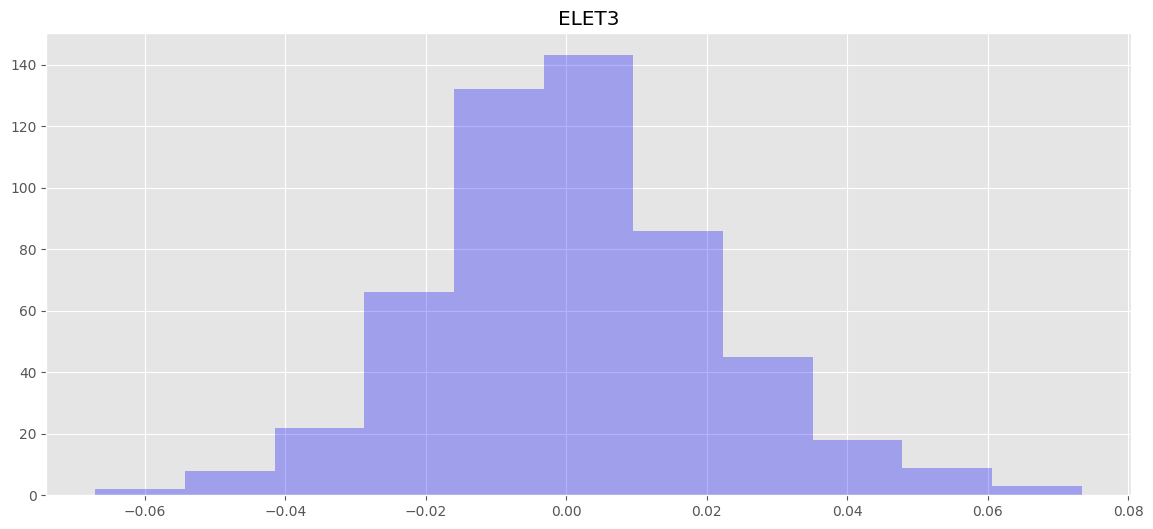

In [148]:
daily_returns = pd.DataFrame()
daily_returns['ELET3'] = data_series[['ELET3']].pct_change()['ELET3'].values[1::]


daily_returns.hist(bins='sturges', alpha = 0.3,color = 'blue')
plt.show()

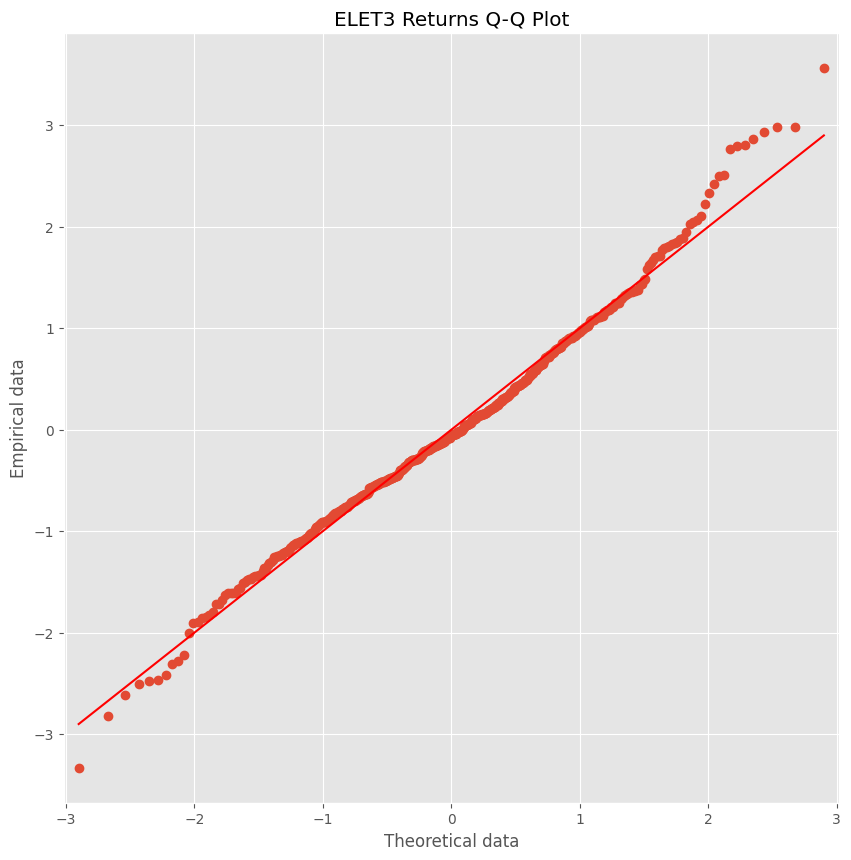

In [149]:

fig, ax = plt.subplots(figsize=(10,10))


sm.qqplot(daily_returns['ELET3'], fit=True, line='s',ax = ax)

plt.title("ELET3 Returns Q-Q Plot")
plt.xlabel("Theoretical data")
plt.ylabel("Empirical data")

plt.show()


### Index

Given that the index contains assets from the same sector and is highly correlated, the application of the technique will be for the behavior of the total index. In cases of a portfolio of uncorrelated assets, the risk is calculated individually for each asset and then aggregated for a total risk.

In [150]:

start_date = dt.datetime(2022, 1, 1)# Look for other windows of 2y (like 2017)
data_series = pd.DataFrame()
# Split treatment is needed 

stocks = ['AESB3', 'ALUP11','AURE3','CMIG4','COCE5','CPLE6','CPFE3','ELET3','ENGI11','ENEV3','EGIE3','EQTL3','NEOE3','SRNA3','TAEE11','TRPL4']
partitions = [6.203 , 6.179 , 6.260 , 6.609 , 5.946 , 6.157 , 6.185 , 6.098 , 6.392 , 6.066 , 6.115 , 6.116 , 6.559 , 6.376 , 6.296 , 6.443] 
for i in range(0,len(stocks)):
    stock = stocks[i]
    weight = partitions[i]
    ticker = yf.Ticker(stock+'.SA')
    serie = ticker.history(period="2y",start=start_date)
    serie.drop(serie.loc[serie['Open']==0].index,inplace=True) # Droping 0 values for stock price
    if(len(serie['Open'].values) != 0 ):
        print(f'{stock} - Portfolio Weight: {weight} %')
        data_series[f'{stock}'] = weight*serie['Open']/100
    else:
        print(f'{stock} data not avaible')
data_series.fillna(method='ffill', inplace=True) # Filling missing days with price of the previous day
data_series['Total'] = data_series.sum(axis=1) # Sum of the stocks weighted price




AESB3 - Portfolio Weight: 6.203 %
ALUP11 - Portfolio Weight: 6.179 %
AURE3 - Portfolio Weight: 6.26 %
CMIG4 - Portfolio Weight: 6.609 %
COCE5 - Portfolio Weight: 5.946 %
CPLE6 - Portfolio Weight: 6.157 %
CPFE3 - Portfolio Weight: 6.185 %
ELET3 - Portfolio Weight: 6.098 %
ENGI11 - Portfolio Weight: 6.392 %
ENEV3 - Portfolio Weight: 6.066 %
EGIE3 - Portfolio Weight: 6.115 %
EQTL3 - Portfolio Weight: 6.116 %
NEOE3 - Portfolio Weight: 6.559 %
SRNA3 - Portfolio Weight: 6.376 %
TAEE11 - Portfolio Weight: 6.296 %
TRPL4 - Portfolio Weight: 6.443 %


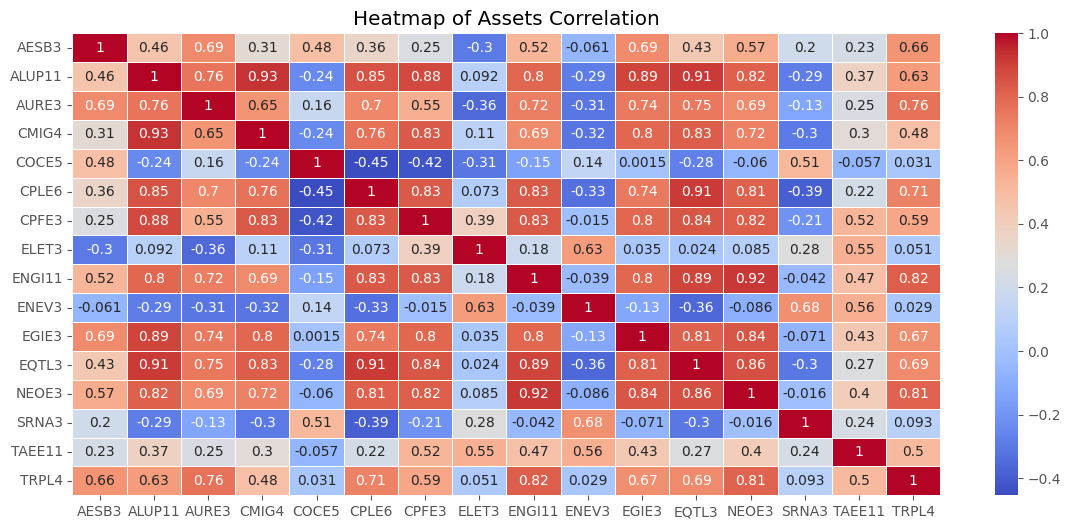

The heatmap shows high correlation between the assets of the Power Index Portfolio


In [151]:
pearson_correlation = data_series[data_series.columns[0:-1]].corr()
plt.figure()
plt.title('Heatmap of Assets Correlation')
sns.heatmap(pearson_correlation, annot=True, cmap='coolwarm', linewidths=.5)
plt.show()
print('The heatmap shows high correlation between the assets of the Power Index Portfolio')

In [152]:
predict = pd.DataFrame()
window_var = []

for i in range(0,len(data_series)-10):
    window = data_series[['Total']].iloc[i:i+10]
    last_price = window.values[-1]
    Daily_return = window.pct_change().values[1:-1]
    Risk = Var(Daily_return)
    # 1% Risk Loss
    Per01 = Risk[2]
    #Value at Risk
    Var01 = last_price*(Per01)
    # Minimun Stock Price
    Min01 = last_price+Var01
    window_var.append(Min01[0])


predict['Date']= data_series.index[10:len(data_series)]
predict['Real'] = data_series[['Total']].values[10:len(data_series)]
predict['Var'] = np.array(window_var)
predict


,Date,Real,Var
0,2022-01-17 00:00:00-03:00,20.425845,19.944982
1,2022-01-18 00:00:00-03:00,20.396215,19.990913
2,2022-01-19 00:00:00-03:00,20.510841,19.962504
3,2022-01-20 00:00:00-03:00,20.698464,20.072210
4,2022-01-21 00:00:00-03:00,20.870339,20.284823
...,...,...,...
520,2024-02-19 00:00:00-03:00,26.449503,25.899652
521,2024-02-20 00:00:00-03:00,26.487002,25.767761
522,2024-02-21 00:00:00-03:00,26.787135,25.834988
523,2024-02-22 00:00:00-03:00,26.634037,26.132347


In [153]:
cross = predict.loc[predict['Real']<=predict['Var']]
print(f'The IEE portifolio crossed the Value at Risk line {len(cross)} times in {len(predict)} days resulting in an {round(100*len(cross)/len(predict),2)}% empirical risk in comparasion to the theorical risk of 1%.')

The IEE portifolio crossed the Value at Risk line 12 times in 525 days resulting in an 2.29% empirical risk in comparasion to the theorical risk of 1%.


The stock price was below the 1% risk line 4 times in 114 days. 
 The percentage of the emprical risk is 3.51%.


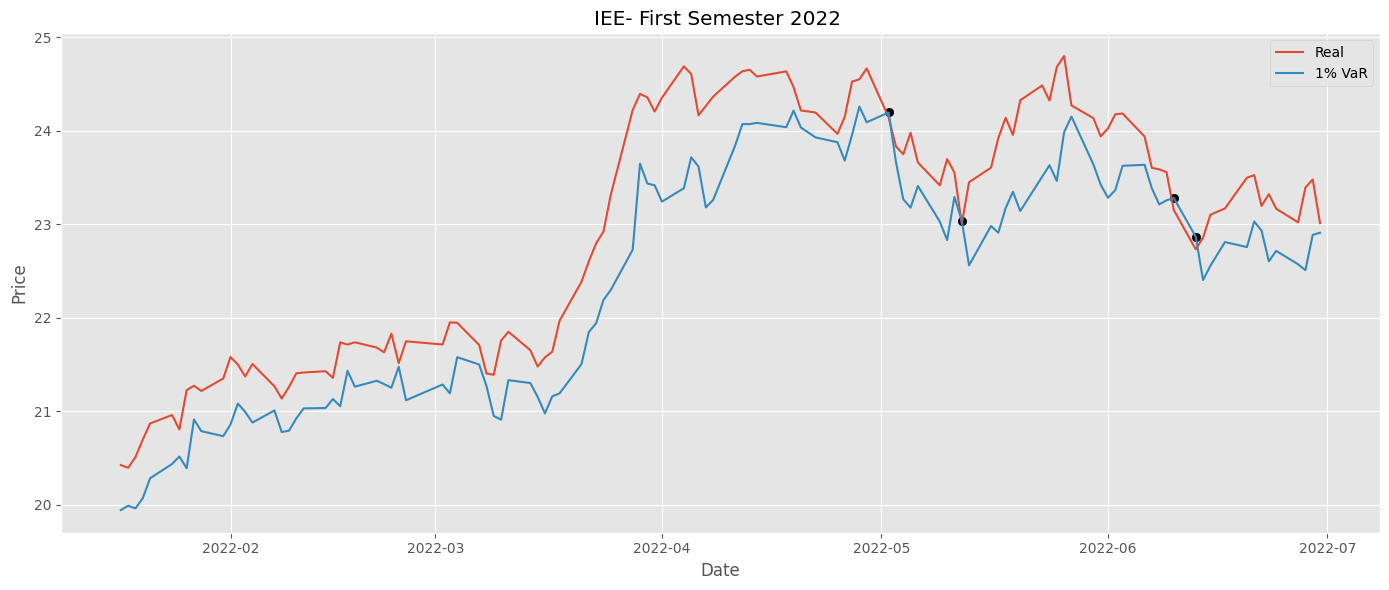

In [154]:
month = 7
year = 2022
#interval = predict[((predict['Date'].dt.month == month1)|(predict['Date'].dt.month == month2))&((predict['Date'].dt.year == year))]
interval = predict[((predict['Date'].dt.month <month )&((predict['Date'].dt.year == year)))]
cross = interval.loc[interval['Real']<=interval['Var']]

empirical_risk = len(cross)/len(interval)
print(f'The stock price was below the 1% risk line {len(cross)} times in {len(interval)} days. \n The percentage of the emprical risk is {round(empirical_risk*100,2)}%.')

plt.figure()
plt.title(f'IEE- First Semester {year} ')
plt.scatter(cross['Date'],cross['Var'],color = 'Black')
plt.plot(interval['Date'],interval['Real'],label = 'Real')
plt.plot(interval['Date'],interval['Var'],label = '1% VaR')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()

The stock price was below the 1% risk line 2 times in 126 days. 
 The percentage of the emprical risk is 1.59%.


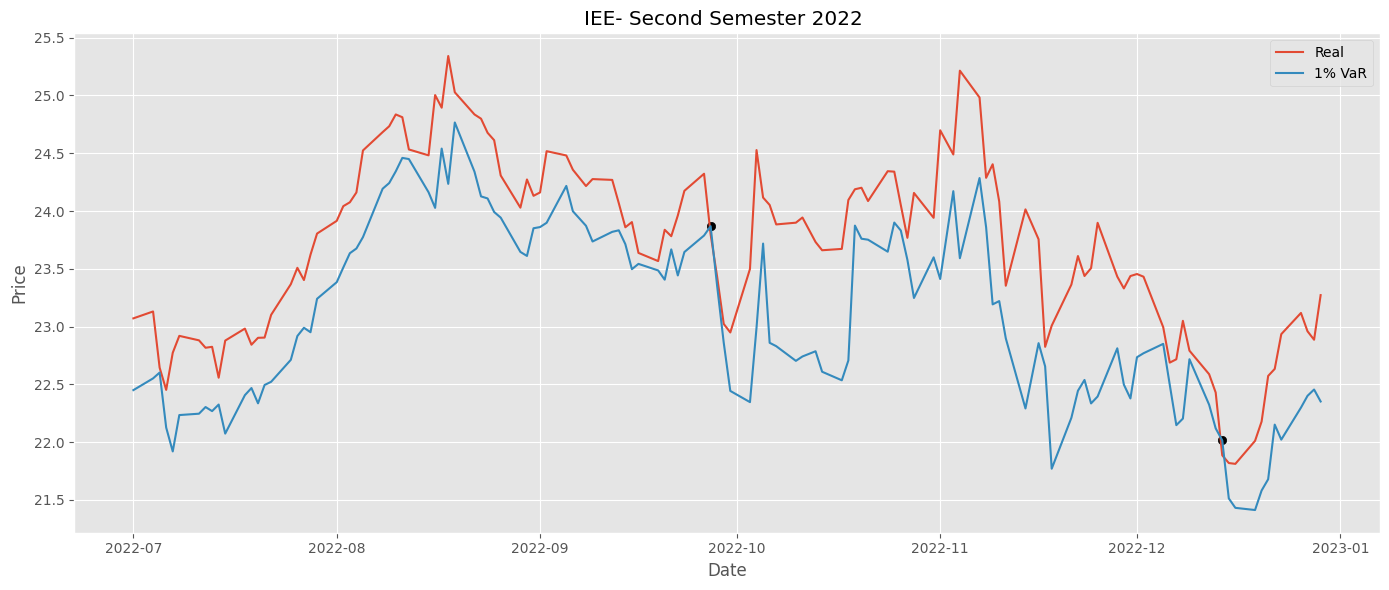

In [155]:
month = 7
year = 2022
#interval = predict[((predict['Date'].dt.month == month1)|(predict['Date'].dt.month == month2))&((predict['Date'].dt.year == year))]
interval = predict[((predict['Date'].dt.month >=month )&((predict['Date'].dt.year == year)))]
cross = interval.loc[interval['Real']<=interval['Var']]

empirical_risk = len(cross)/len(interval)
print(f'The stock price was below the 1% risk line {len(cross)} times in {len(interval)} days. \n The percentage of the emprical risk is {round(empirical_risk*100,2)}%.')

plt.figure()
plt.title(f'IEE- Second Semester {year} ')
plt.scatter(cross['Date'],cross['Var'],color = 'Black')
plt.plot(interval['Date'],interval['Real'],label = 'Real')
plt.plot(interval['Date'],interval['Var'],label = '1% VaR')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()

The stock price was below the 1% risk line 1 times in 124 days. 
 The percentage of the emprical risk is 0.81%.


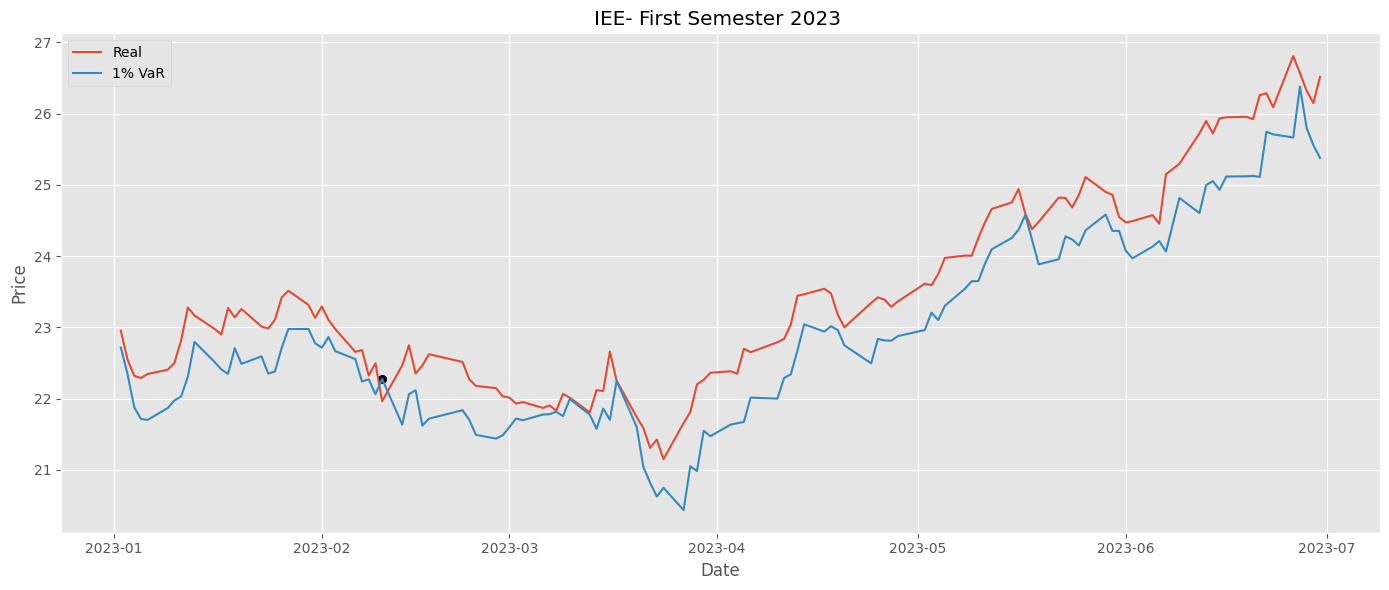

In [156]:
month = 7
year = 2023
#interval = predict[((predict['Date'].dt.month == month1)|(predict['Date'].dt.month == month2))&((predict['Date'].dt.year == year))]
interval = predict[((predict['Date'].dt.month <month )&((predict['Date'].dt.year == year)))]
cross = interval.loc[interval['Real']<=interval['Var']]

empirical_risk = len(cross)/len(interval)
print(f'The stock price was below the 1% risk line {len(cross)} times in {len(interval)} days. \n The percentage of the emprical risk is {round(empirical_risk*100,2)}%.')

plt.figure()
plt.title(f'IEE- First Semester {year} ')
plt.scatter(cross['Date'],cross['Var'],color = 'Black')
plt.plot(interval['Date'],interval['Real'],label = 'Real')
plt.plot(interval['Date'],interval['Var'],label = '1% VaR')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()

The stock price was below the 1% risk line 4 times in 124 days. 
 The percentage of the emprical risk is 3.23%.


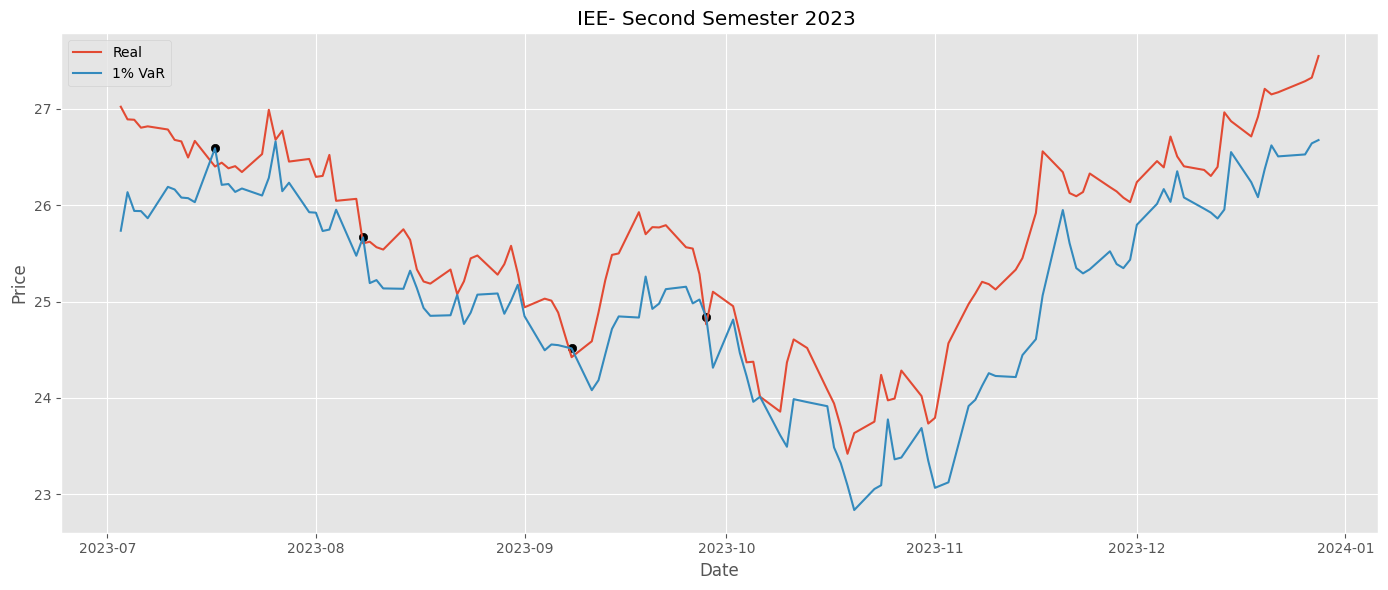

In [157]:
month = 7
year = 2023
#interval = predict[((predict['Date'].dt.month == month1)|(predict['Date'].dt.month == month2))&((predict['Date'].dt.year == year))]
interval = predict[((predict['Date'].dt.month >=month )&((predict['Date'].dt.year == year)))]
cross = interval.loc[interval['Real']<=interval['Var']]

empirical_risk = len(cross)/len(interval)
print(f'The stock price was below the 1% risk line {len(cross)} times in {len(interval)} days. \n The percentage of the emprical risk is {round(empirical_risk*100,2)}%.')

plt.figure()
plt.title(f'IEE- Second Semester {year} ')
plt.scatter(cross['Date'],cross['Var'],color = 'Black')
plt.plot(interval['Date'],interval['Real'],label = 'Real')
plt.plot(interval['Date'],interval['Var'],label = '1% VaR')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()

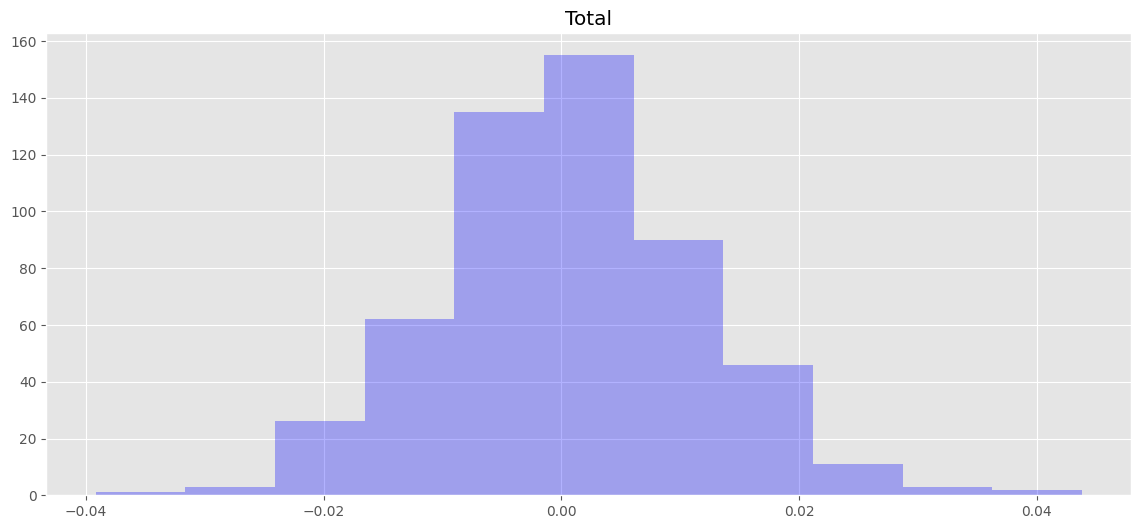

In [158]:
daily_returns = pd.DataFrame()
daily_returns['Total'] = data_series[['Total']].pct_change()['Total'].values[1::]


daily_returns.hist(bins='sturges', alpha = 0.3,color = 'blue')
plt.show()

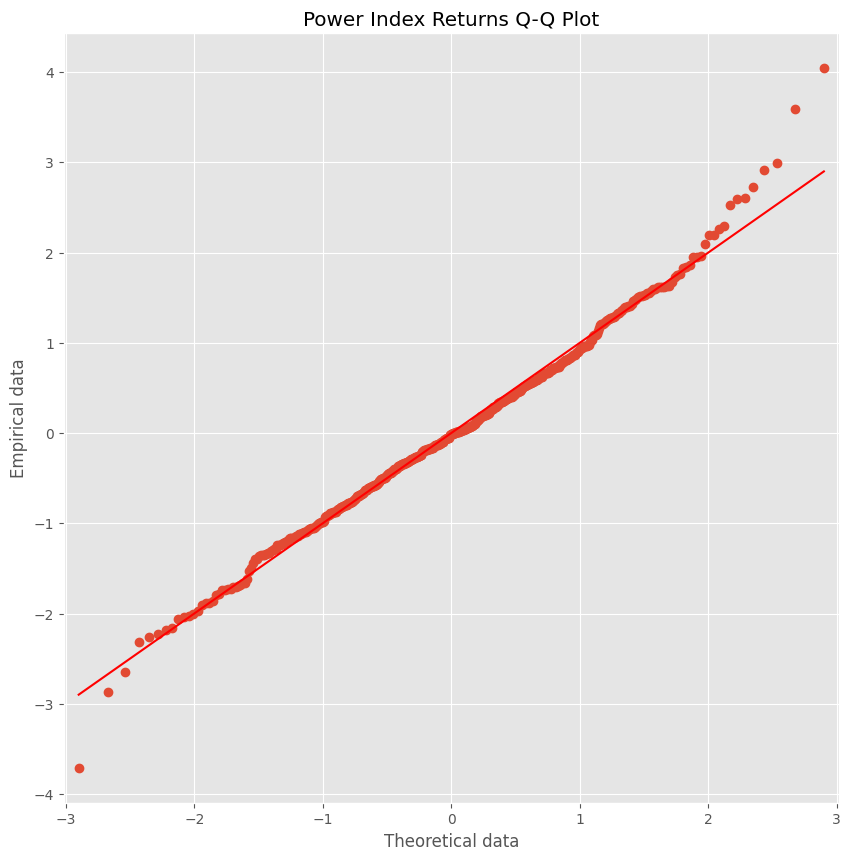

In [160]:

fig, ax = plt.subplots(figsize=(10,10))


sm.qqplot(daily_returns['Total'], fit=True, line='s',ax = ax)

plt.title("Power Index Returns Q-Q Plot")
plt.xlabel("Theoretical data")
plt.ylabel("Empirical data")

plt.show()


### Conclusion

The 1% pattern and a 10-day window follow Basel Committee recommendations to generate a time series that represents the minimum value in the asset price to stay within the 1% risk margin. Despite adhering to Basel Committee guidelines, the empirical risk exceeded expectations. In other words, the frequency of intersections between the actual price series of the asset and the VaR-generated series surpasses 1%.

The main limitation of the method lies in the assumed hypothesis; the presupposition that daily returns follow a normal distribution is a very strong statement and a recurring issue. Even though daily returns may appear to be normally distributed, the Q-Q plot demonstrates a long-tailed behavior in the distribution, which poses challenges for tools based on extreme values, such as VaR